In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [4]:
!kaggle datasets download -d mmoreaux/environmental-sound-classification-50

100% 1.42G/1.42G [00:52<00:00, 30.8MB/s]
100% 1.42G/1.42G [00:52<00:00, 29.1MB/s]


In [11]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: audio/audio/16000/2-188822-C-40.wav  
  inflating: audio/audio/16000/2-188822-D-40.wav  
  inflating: audio/audio/16000/2-196688-A-8.wav  
  inflating: audio/audio/16000/2-205966-A-16.wav  
  inflating: audio/audio/16000/2-209471-A-25.wav  
  inflating: audio/audio/16000/2-209472-A-25.wav  
  inflating: audio/audio/16000/2-209473-A-25.wav  
  inflating: audio/audio/16000/2-209474-A-25.wav  
  inflating: audio/audio/16000/2-209475-A-25.wav  
  inflating: audio/audio/16000/2-209476-A-25.wav  
  inflating: audio/audio/16000/2-209477-A-25.wav  
  inflating: audio/audio/16000/2-209478-A-25.wav  
  inflating: audio/audio/16000/2-250710-A-39.wav  
  inflating: audio/audio/16000/2-25292-A-22.wav  
  inflating: audio/audio/16000/2-25293-A-22.wav  
  inflating: audio/audio/16000/2-262579-A-45.wav  
  inflating: audio/audio/16000/2-28314-A-12.wav  
  inflating: audio/audio/16000/2-28314-B-12.wav  
  inflating: audio/audio/16000/2-303

In [12]:
df = pd.read_csv('esc50.csv')
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [88]:
import matplotlib.pyplot as plt

#for loading and visualizing audio files
import librosa
import librosa.display
from tqdm import tqdm
#to play audio
import IPython.display as ipd
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, Flatten, Bidirectional, BatchNormalization
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
import os
import shutil
if os.path.exists('./prep/'):
    shutil.rmtree('./prep/')
label_csv = '/content/esc50.csv'
audio_fpath = "/content/audio/audio"

In [85]:
class AudioAugmentation:
    
    def read_audio_file(self, file_path):
        input_length = 220500
        data = librosa.load(file_path)[0]
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data
    
    def add_noise(self, data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.005 * noise
        return data_noise
    
    def shift(self, data):
        return np.roll(data, 22050)
    
    def stretch(self, data, rate=1):
        input_length = 220500
        data = librosa.effects.time_stretch(data, rate)
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data
    def write_audio_file(self, file, data, sample_rate=44100):
        librosa.output.write_wav(file, data, sample_rate)

In [86]:
def create_dir(dirname):
    if os.path.exists(dirname):
        pass
    else:
        os.makedirs(dirname)
        
def wav2mel(path, clip, output, sample_rate=44100):
    x, sr = librosa.load(path+clip, sr=sample_rate)
    sgram=librosa.stft(x)
    sgram_mag, _ = librosa.magphase(sgram)
    
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.savefig(output)
    plt.clf()

In [89]:

audio_clips = os.listdir(audio_fpath)
print("No. of .wav files in audio folder = ",len(audio_clips))
df = pd.read_csv(label_csv, 
#                  usecols=['filename', 'target', 'category']
#                  , index_col=['filename']
                )

print(df.head())  
df.shape

No. of .wav files in audio folder =  2002
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


(2000, 7)

In [26]:
x, sr = librosa.load(audio_fpath + '/' + audio_clips[0], sr=44100)

print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(220500,) 44100


In [27]:
feature = librosa.feature.mfcc(y=x, sr = 44100)
print(feature.shape)

(20, 431)


In [45]:
pip install --upgrade librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
aa = AudioAugmentation()
extracted_data = []
for index, row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_fpath),str(row["filename"]))
    class_labels = row['category']
    y, sr = librosa.load(file_name, sr=44100)
    for i in range(8):
        if i == 1 or i >3:
            data = aa.add_noise(y)
        if i%3 == 2 or i == 7:
            data = aa.shift(y)
        if i%3 == 0 or i == 7:
            data = librosa.effects.time_stretch(y, rate=1.25)
        feature = librosa.feature.mfcc(y=data, sr=sr)
        scaled_feature = np.mean(feature.T,axis=0)
        extracted_data.append([scaled_feature, class_labels])
np.array(extracted_data).shape

2000it [23:00,  1.45it/s]
<ipython-input-47-6c5791847e92>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(extracted_data).shape


(16000, 2)

In [50]:
feature_df = pd.DataFrame(extracted_data, columns=['feature','class'])

print(feature_df.head())

                                             feature class
0  [-627.4933, 8.655039, -7.0353813, -4.395152, -...   dog
1  [-344.5256451877179, -1.1477303624479231, -4.8...   dog
2  [-580.6255, 8.185607, -6.650708, -4.2932887, -...   dog
3  [-627.4933, 8.655039, -7.0353813, -4.395152, -...   dog
4  [-343.94518517291056, -0.9357893863279829, -4....   dog


In [51]:
x = np.array(feature_df['feature'].tolist())

x.shape

(16000, 20)

In [52]:
target = np.array(feature_df['class'].tolist())

In [53]:
y_new = pd.get_dummies(target)
print(y_new.shape)
y_new.head()

(16000, 50)


,airplane,breathing,brushing_teeth,can_opening,car_horn,cat,chainsaw,chirping_birds,church_bells,clapping,...,siren,sneezing,snoring,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y_new, 
                                                    test_size=0.2, 
                                                    random_state=15)

print(str(X_train.shape)+ ', ' + str(X_test.shape))
inp = (1, 20)
np.array(X_train).reshape(12800, 1, 20)

(12800, 20), (3200, 20)


array([[[-2.56953125e+02,  1.75271988e+02,  1.08140059e+01, ...,
          1.53361666e+00,  2.38381433e+00,  2.63143301e+00]],

       [[-2.48773819e+02,  1.77570923e+02, -3.30623932e+01, ...,
         -1.17200260e+01, -4.69750071e+00, -3.37107956e-01]],

       [[-2.77115912e+02,  4.12110906e+01, -1.89904391e+00, ...,
         -3.24273341e+00, -2.75537495e+00, -4.17094551e+00]],

       ...,

       [[-2.63042116e+02,  3.93623299e+01, -2.66876558e+01, ...,
          1.13298169e+01,  1.51817898e+01,  1.01993881e+01]],

       [[-4.10132599e+02,  7.92368927e+01,  2.64401722e+00, ...,
         -8.99709046e-01,  3.35299969e+00,  7.97791386e+00]],

       [[-5.47295288e+02,  9.89113693e+01,  1.65591407e+00, ...,
          1.66534513e-01,  8.06731510e+00, -3.56568962e-01]]])

In [55]:
np.array(X_train).reshape(12800,1,20)

array([[[-2.56953125e+02,  1.75271988e+02,  1.08140059e+01, ...,
          1.53361666e+00,  2.38381433e+00,  2.63143301e+00]],

       [[-2.48773819e+02,  1.77570923e+02, -3.30623932e+01, ...,
         -1.17200260e+01, -4.69750071e+00, -3.37107956e-01]],

       [[-2.77115912e+02,  4.12110906e+01, -1.89904391e+00, ...,
         -3.24273341e+00, -2.75537495e+00, -4.17094551e+00]],

       ...,

       [[-2.63042116e+02,  3.93623299e+01, -2.66876558e+01, ...,
          1.13298169e+01,  1.51817898e+01,  1.01993881e+01]],

       [[-4.10132599e+02,  7.92368927e+01,  2.64401722e+00, ...,
         -8.99709046e-01,  3.35299969e+00,  7.97791386e+00]],

       [[-5.47295288e+02,  9.89113693e+01,  1.65591407e+00, ...,
          1.66534513e-01,  8.06731510e+00, -3.56568962e-01]]])

In [56]:
model = Sequential()
#new_model.add(Embedding(2000, 256))
model.add(Input(shape = (1,20)))
model.add(Bidirectional(LSTM(1024, return_sequences = True, recurrent_dropout = 0.1)))

# model.add(LSTM(256, return_sequences = True))
# model.add(Flatten())
# model.add(LSTM(256,dropout = 0.2, recurrent_dropout=0.2))
model.add(Flatten())
# model.add(BatchNormalization())
# new_model.add(BatchNormalization())
# new_model.add(Dense(256, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(BatchNormalization())
# new_model.add(Dense(128, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(BatchNormalization())
# new_model.add(Dense(64, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='softmax'))
adam = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', AUC()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 2048)          8560640   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 50)                102450    
                                                                 
Total params: 8,663,090
Trainable params: 8,663,090
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
es = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=30, min_delta = 0.001
)
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.5,
                        min_lr=0.00001)
# new_model.fit(datagen.flow_from_dataframe(
#     X_train,
#     x_col="path",
#     y_col="category",
#     batch_size=100, 
#     directory = './prep'
# ),
#               validation_data=datagen.flow_from_dataframe(
#             X_test,
#             x_col="path",
#             y_col="category",
#                   batch_size=64, 
#                   directory = './prep'),
#               epochs=500,
#               callbacks=[es])
history=model.fit(np.array(X_train).reshape(12800, 1, 20),
        np.array(y_train),
        epochs=50,
        callbacks = [es],
        shuffle = True,
        batch_size = 100,
#         steps_per_epoch = 4,
        validation_data = (np.array(X_test).reshape(3200,1,20),
                            np.array(y_test))
                           )
model.save('LSTM_ESC50_Training_Model')

Epoch 1/50
128/128 [==============================] - 36s 280ms/step - loss: 1.8160 - accuracy: 0.4818 - auc: 0.9545 - val_loss: 1.5972 - val_accuracy: 0.5466 - val_auc: 0.9652
Epoch 2/50
128/128 [==============================] - 34s 269ms/step - loss: 1.3629 - accuracy: 0.6126 - auc: 0.9762 - val_loss: 1.2683 - val_accuracy: 0.6303 - val_auc: 0.9786
Epoch 3/50
128/128 [==============================] - 36s 281ms/step - loss: 1.0614 - accuracy: 0.7066 - auc: 0.9862 - val_loss: 1.0252 - val_accuracy: 0.7194 - val_auc: 0.9862
Epoch 4/50
128/128 [==============================] - 34s 266ms/step - loss: 0.8455 - accuracy: 0.7722 - auc: 0.9914 - val_loss: 0.8579 - val_accuracy: 0.7575 - val_auc: 0.9906
Epoch 5/50
128/128 [==============================] - 35s 274ms/step - loss: 0.6897 - accuracy: 0.8191 - auc: 0.9944 - val_loss: 0.7080 - val_accuracy: 0.8125 - val_auc: 0.9932
Epoch 6/50
128/128 [==============================] - 35s 271ms/step - loss: 0.5769 - accuracy: 0.8525 - auc: 0.996

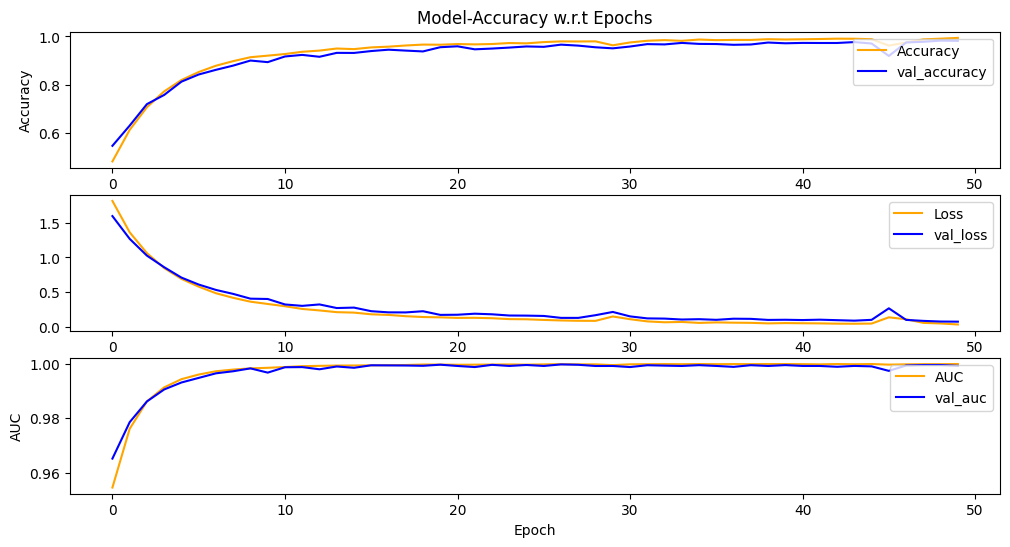

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(12,6))
ax2.plot(history.history['loss'], color='orange', label='Loss')
ax2.plot(history.history['val_loss'], color='blue', label='val_loss')
ax2.legend(loc='upper right')
ax1.plot(history.history['accuracy'], label='Accuracy', color='orange')
ax1.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
ax1.legend(loc="upper right")
ax1.set_title("Model-Accuracy w.r.t Epochs", loc='center')
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax3.plot(history.history['auc'], color='orange', label='AUC')
ax3.plot(history.history['val_auc'], color='blue', label='val_auc')
ax3.set_xlabel("Epoch")
ax3.set_ylabel("AUC")
ax3.legend(loc='upper right')
plt.savefig('model_acc_LSTM_ESC50.png')

In [60]:
y_pred = model.predict(np.array(x).reshape(16000, 1,20))

500/500 [==============================] - 19s 35ms/step


In [61]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [62]:
y_pred_classes

array([18, 18, 18, ..., 18, 18, 18])

In [63]:
y_true = np.argmax(np.array(y_new), axis=1)

In [64]:
y_true

array([18, 18, 18, ..., 18, 18, 18])

In [65]:
print(np.mean(y_pred_classes == y_true))
m = AUC()
m.update_state(y_new, y_pred)
print(m.result())

0.991875
tf.Tensor(0.99986476, shape=(), dtype=float32)


<Figure size 640x480 with 0 Axes>

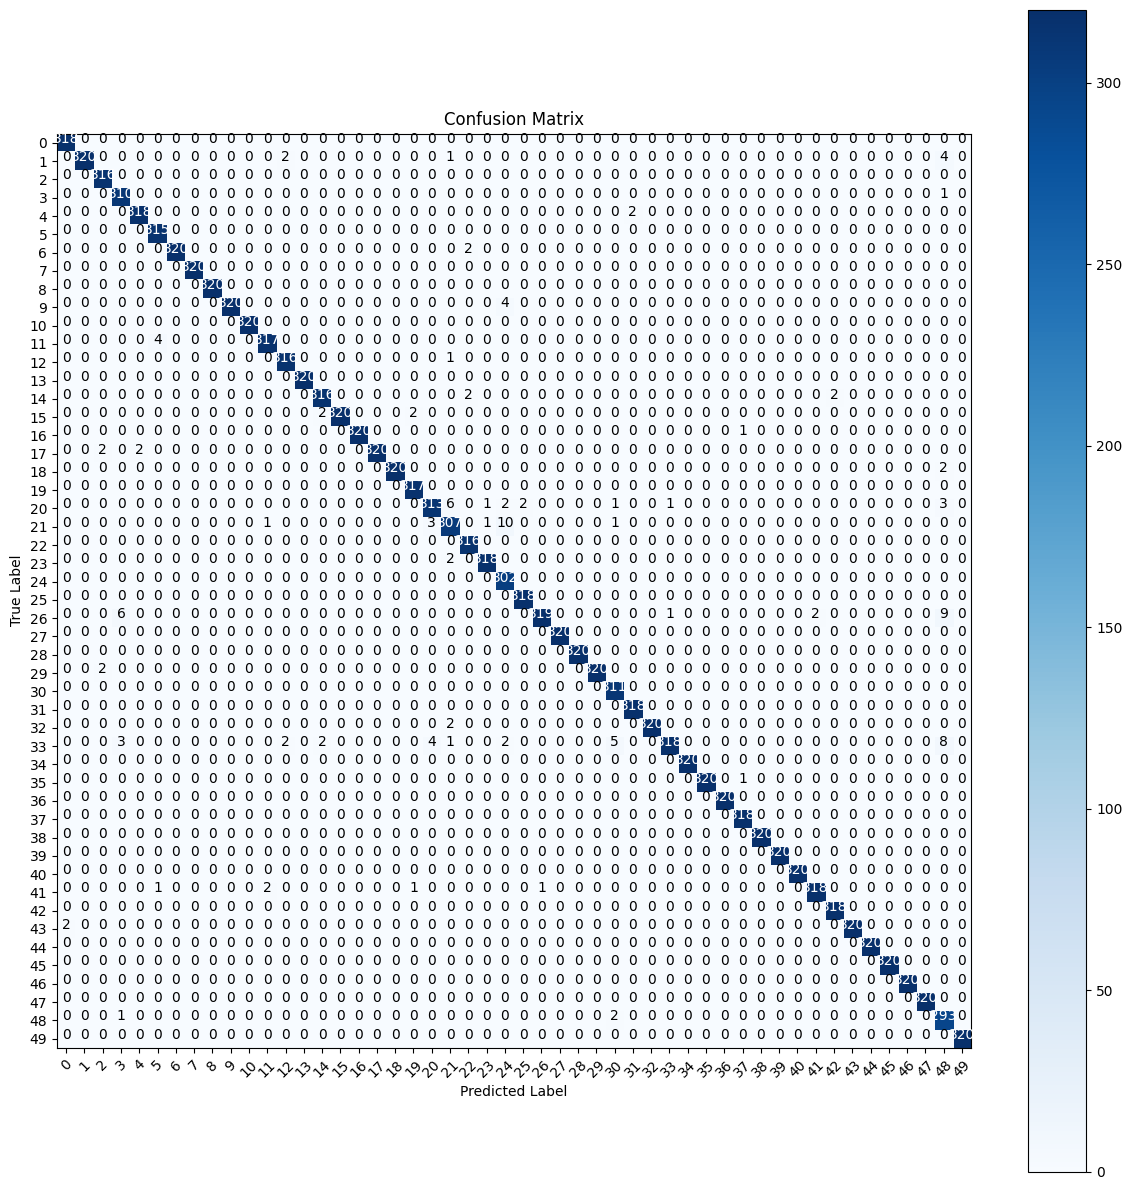

In [66]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_classes, y_true,)
import itertools
plt.clf()
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.imshow(cm, cmap = plt.cm.Blues, interpolation='nearest')

plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(range(50)))
plt.xticks(tick_marks, range(50), rotation=45)
plt.yticks(tick_marks, range(50))
thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i , cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")

plt.tight_layout()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig('con_matrix_LSTM_ESC50.png')

In [90]:
test_results = []
answers = []
audio_lpath = '/content/audio/audio/44100/'
for index, row in tqdm(df.iterrows()):
    x,sr = librosa.load(audio_lpath+row['filename'], sr=44100)
    mfcc = librosa.feature.mfcc(y=x, sr=sr)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    sample = np.array(mfcc_mean).reshape(1, 1, 20)
    pred = model.predict(sample)
    pred_class = np.argmax(pred,axis=1 )
#     print(pred_class[0])
#     print(row['target'])
    test_results.append(pred_class[0])
    answers.append(row['category'])
print(np.mean(np.array(test_results) == np.array(answers)))

0it [00:00, ?it/s]

1/1 [==============================] - 0s 435ms/step


1it [00:00,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


2it [00:00,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


3it [00:00,  4.32it/s]

1/1 [==============================] - 0s 39ms/step


4it [00:00,  5.37it/s]

1/1 [==============================] - 0s 45ms/step


5it [00:01,  6.05it/s]

1/1 [==============================] - 0s 43ms/step


6it [00:01,  6.53it/s]

1/1 [==============================] - 0s 39ms/step


7it [00:01,  7.01it/s]

1/1 [==============================] - 0s 39ms/step


8it [00:01,  7.21it/s]

1/1 [==============================] - 0s 41ms/step


9it [00:01,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


10it [00:01,  7.73it/s]

1/1 [==============================] - 0s 43ms/step


11it [00:01,  7.40it/s]

1/1 [==============================] - 0s 37ms/step


12it [00:01,  7.71it/s]

1/1 [==============================] - 0s 45ms/step


13it [00:02,  7.89it/s]

1/1 [==============================] - 0s 37ms/step


14it [00:02,  8.11it/s]

1/1 [==============================] - 0s 41ms/step


15it [00:02,  8.20it/s]

1/1 [==============================] - 0s 44ms/step


16it [00:02,  8.04it/s]

1/1 [==============================] - 0s 55ms/step


17it [00:02,  7.84it/s]

1/1 [==============================] - 0s 43ms/step


18it [00:02,  7.95it/s]

1/1 [==============================] - 0s 44ms/step


19it [00:02,  7.86it/s]

1/1 [==============================] - 0s 42ms/step


20it [00:02,  7.71it/s]

1/1 [==============================] - 0s 50ms/step


21it [00:03,  7.78it/s]

1/1 [==============================] - 0s 33ms/step


22it [00:03,  8.04it/s]

1/1 [==============================] - 0s 37ms/step


23it [00:03,  8.25it/s]

1/1 [==============================] - 0s 42ms/step


24it [00:03,  7.68it/s]

1/1 [==============================] - 0s 42ms/step


25it [00:03,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


26it [00:03,  7.93it/s]

1/1 [==============================] - 0s 40ms/step


27it [00:03,  8.02it/s]

1/1 [==============================] - 0s 44ms/step


28it [00:04,  7.62it/s]

1/1 [==============================] - 0s 49ms/step


29it [00:04,  7.27it/s]

1/1 [==============================] - 0s 38ms/step


30it [00:04,  7.69it/s]

1/1 [==============================] - 0s 35ms/step


31it [00:04,  7.86it/s]

1/1 [==============================] - 0s 38ms/step


32it [00:04,  7.95it/s]

1/1 [==============================] - 0s 36ms/step


33it [00:04,  8.07it/s]

1/1 [==============================] - 0s 45ms/step


34it [00:04,  7.83it/s]

1/1 [==============================] - 0s 42ms/step


35it [00:04,  7.86it/s]

1/1 [==============================] - 0s 36ms/step


36it [00:05,  7.86it/s]

1/1 [==============================] - 0s 38ms/step


37it [00:05,  7.85it/s]

1/1 [==============================] - 0s 41ms/step


38it [00:05,  7.81it/s]

1/1 [==============================] - 0s 42ms/step


39it [00:05,  7.66it/s]

1/1 [==============================] - 0s 38ms/step


40it [00:05,  7.83it/s]

1/1 [==============================] - 0s 35ms/step


41it [00:05,  7.32it/s]

1/1 [==============================] - 0s 41ms/step


42it [00:05,  7.66it/s]

1/1 [==============================] - 0s 38ms/step


43it [00:05,  8.00it/s]

1/1 [==============================] - 0s 33ms/step


44it [00:06,  8.36it/s]

1/1 [==============================] - 0s 30ms/step


45it [00:06,  8.58it/s]

1/1 [==============================] - 0s 38ms/step


46it [00:06,  8.30it/s]

1/1 [==============================] - 0s 44ms/step


47it [00:06,  8.14it/s]

1/1 [==============================] - 0s 40ms/step


48it [00:06,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


49it [00:06,  8.17it/s]

1/1 [==============================] - 0s 32ms/step


50it [00:06,  8.32it/s]

1/1 [==============================] - 0s 33ms/step


51it [00:06,  8.57it/s]

1/1 [==============================] - 0s 40ms/step


52it [00:06,  8.50it/s]

1/1 [==============================] - 0s 37ms/step


53it [00:07,  8.49it/s]

1/1 [==============================] - 0s 37ms/step


54it [00:07,  8.21it/s]

1/1 [==============================] - 0s 36ms/step


55it [00:07,  7.81it/s]

1/1 [==============================] - 0s 37ms/step


56it [00:07,  8.15it/s]

1/1 [==============================] - 0s 36ms/step


57it [00:07,  8.16it/s]

1/1 [==============================] - 0s 37ms/step


58it [00:07,  8.23it/s]

1/1 [==============================] - 0s 40ms/step


59it [00:07,  8.14it/s]

1/1 [==============================] - 0s 38ms/step


60it [00:07,  8.07it/s]

1/1 [==============================] - 0s 36ms/step


61it [00:08,  8.12it/s]

1/1 [==============================] - 0s 52ms/step


62it [00:08,  7.88it/s]

1/1 [==============================] - 0s 42ms/step


63it [00:08,  8.00it/s]

1/1 [==============================] - 0s 44ms/step


64it [00:08,  7.49it/s]

1/1 [==============================] - 0s 37ms/step


65it [00:08,  7.63it/s]

1/1 [==============================] - 0s 40ms/step


66it [00:08,  7.74it/s]

1/1 [==============================] - 0s 38ms/step


67it [00:08,  7.56it/s]

1/1 [==============================] - 0s 31ms/step


68it [00:09,  7.98it/s]

1/1 [==============================] - 0s 36ms/step


69it [00:09,  8.20it/s]

1/1 [==============================] - 0s 38ms/step


70it [00:09,  8.34it/s]

1/1 [==============================] - 0s 37ms/step


71it [00:09,  8.38it/s]

1/1 [==============================] - 0s 44ms/step


72it [00:09,  8.11it/s]

1/1 [==============================] - 0s 39ms/step


73it [00:09,  8.18it/s]

1/1 [==============================] - 0s 39ms/step


74it [00:09,  8.10it/s]

1/1 [==============================] - 0s 36ms/step


75it [00:09,  8.08it/s]

1/1 [==============================] - 0s 38ms/step


76it [00:09,  8.04it/s]

1/1 [==============================] - 0s 40ms/step


77it [00:10,  7.82it/s]

1/1 [==============================] - 0s 47ms/step


78it [00:10,  6.50it/s]

1/1 [==============================] - 0s 39ms/step


79it [00:10,  6.00it/s]

1/1 [==============================] - 0s 46ms/step


80it [00:10,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


81it [00:10,  5.51it/s]

1/1 [==============================] - 0s 55ms/step


82it [00:11,  5.41it/s]

1/1 [==============================] - 0s 40ms/step


83it [00:11,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


84it [00:11,  6.23it/s]

1/1 [==============================] - 0s 37ms/step


85it [00:11,  6.75it/s]

1/1 [==============================] - 0s 35ms/step


86it [00:11,  7.33it/s]

1/1 [==============================] - 0s 77ms/step


87it [00:11,  6.46it/s]

1/1 [==============================] - 0s 45ms/step


88it [00:12,  5.97it/s]

1/1 [==============================] - 0s 46ms/step


89it [00:12,  5.57it/s]

1/1 [==============================] - 0s 42ms/step


90it [00:12,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


91it [00:12,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


92it [00:12,  6.50it/s]

1/1 [==============================] - 0s 49ms/step


93it [00:12,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


94it [00:12,  7.32it/s]

1/1 [==============================] - 0s 40ms/step


95it [00:13,  7.54it/s]

1/1 [==============================] - 0s 40ms/step


96it [00:13,  7.77it/s]

1/1 [==============================] - 0s 57ms/step


97it [00:13,  7.56it/s]

1/1 [==============================] - 0s 36ms/step


98it [00:13,  7.38it/s]

1/1 [==============================] - 0s 36ms/step


99it [00:13,  7.63it/s]

1/1 [==============================] - 0s 37ms/step


100it [00:13,  7.80it/s]

1/1 [==============================] - 0s 46ms/step


101it [00:13,  7.88it/s]

1/1 [==============================] - 0s 36ms/step


102it [00:13,  8.17it/s]

1/1 [==============================] - 0s 39ms/step


103it [00:14,  8.01it/s]

1/1 [==============================] - 0s 31ms/step


104it [00:14,  8.01it/s]

1/1 [==============================] - 0s 33ms/step


105it [00:14,  8.17it/s]

1/1 [==============================] - 0s 48ms/step


106it [00:14,  7.96it/s]

1/1 [==============================] - 0s 39ms/step


107it [00:14,  7.96it/s]

1/1 [==============================] - 0s 41ms/step


108it [00:14,  7.79it/s]

1/1 [==============================] - 0s 47ms/step


109it [00:14,  7.30it/s]

1/1 [==============================] - 0s 36ms/step


110it [00:14,  7.67it/s]

1/1 [==============================] - 0s 41ms/step


111it [00:15,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


112it [00:15,  7.92it/s]

1/1 [==============================] - 0s 42ms/step


113it [00:15,  7.73it/s]

1/1 [==============================] - 0s 36ms/step


114it [00:15,  7.63it/s]

1/1 [==============================] - 0s 36ms/step


115it [00:15,  7.93it/s]

1/1 [==============================] - 0s 40ms/step


116it [00:15,  7.99it/s]

1/1 [==============================] - 0s 40ms/step


117it [00:15,  7.88it/s]

1/1 [==============================] - 0s 63ms/step


118it [00:15,  7.49it/s]

1/1 [==============================] - 0s 40ms/step


119it [00:16,  7.76it/s]

1/1 [==============================] - 0s 35ms/step


120it [00:16,  7.87it/s]

1/1 [==============================] - 0s 39ms/step


121it [00:16,  7.99it/s]

1/1 [==============================] - 0s 40ms/step


122it [00:16,  8.00it/s]

1/1 [==============================] - 0s 39ms/step


123it [00:16,  8.13it/s]

1/1 [==============================] - 0s 41ms/step


124it [00:16,  8.11it/s]

1/1 [==============================] - 0s 36ms/step


125it [00:16,  7.84it/s]

1/1 [==============================] - 0s 42ms/step


126it [00:16,  7.78it/s]

1/1 [==============================] - 0s 42ms/step


127it [00:17,  7.91it/s]

1/1 [==============================] - 0s 49ms/step


128it [00:17,  7.75it/s]

1/1 [==============================] - 0s 42ms/step


129it [00:17,  7.76it/s]

1/1 [==============================] - 0s 49ms/step


130it [00:17,  7.75it/s]

1/1 [==============================] - 0s 40ms/step


131it [00:17,  7.69it/s]

1/1 [==============================] - 0s 39ms/step


132it [00:17,  7.78it/s]

1/1 [==============================] - 0s 39ms/step


133it [00:17,  7.87it/s]

1/1 [==============================] - 0s 33ms/step


134it [00:17,  8.15it/s]

1/1 [==============================] - 0s 38ms/step


135it [00:18,  7.87it/s]

1/1 [==============================] - 0s 36ms/step


136it [00:18,  8.16it/s]

1/1 [==============================] - 0s 37ms/step


137it [00:18,  8.18it/s]

1/1 [==============================] - 0s 50ms/step


138it [00:18,  7.90it/s]

1/1 [==============================] - 0s 36ms/step


139it [00:18,  8.07it/s]

1/1 [==============================] - 0s 67ms/step


140it [00:18,  7.54it/s]

1/1 [==============================] - 0s 36ms/step


141it [00:18,  7.81it/s]

1/1 [==============================] - 0s 40ms/step


142it [00:19,  7.68it/s]

1/1 [==============================] - 0s 37ms/step


143it [00:19,  7.68it/s]

1/1 [==============================] - 0s 37ms/step


144it [00:19,  7.82it/s]

1/1 [==============================] - 0s 39ms/step


145it [00:19,  7.72it/s]

1/1 [==============================] - 0s 40ms/step


146it [00:19,  7.56it/s]

1/1 [==============================] - 0s 35ms/step


147it [00:19,  7.69it/s]

1/1 [==============================] - 0s 41ms/step


148it [00:19,  7.62it/s]

1/1 [==============================] - 0s 38ms/step


149it [00:19,  7.87it/s]

1/1 [==============================] - 0s 35ms/step


150it [00:20,  8.10it/s]

1/1 [==============================] - 0s 43ms/step


151it [00:20,  7.80it/s]

1/1 [==============================] - 0s 43ms/step


152it [00:20,  7.69it/s]

1/1 [==============================] - 0s 46ms/step


153it [00:20,  7.75it/s]

1/1 [==============================] - 0s 41ms/step


154it [00:20,  7.50it/s]

1/1 [==============================] - 0s 44ms/step


155it [00:20,  7.67it/s]

1/1 [==============================] - 0s 35ms/step


156it [00:20,  7.83it/s]

1/1 [==============================] - 0s 33ms/step


157it [00:20,  7.88it/s]

1/1 [==============================] - 0s 41ms/step


158it [00:21,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


159it [00:21,  8.05it/s]

1/1 [==============================] - 0s 38ms/step


160it [00:21,  7.94it/s]

1/1 [==============================] - 0s 46ms/step


161it [00:21,  7.69it/s]

1/1 [==============================] - 0s 45ms/step


162it [00:21,  7.57it/s]

1/1 [==============================] - 0s 35ms/step


163it [00:21,  7.69it/s]

1/1 [==============================] - 0s 37ms/step


164it [00:21,  7.71it/s]

1/1 [==============================] - 0s 42ms/step


165it [00:21,  7.72it/s]

1/1 [==============================] - 0s 34ms/step


166it [00:22,  7.89it/s]

1/1 [==============================] - 0s 34ms/step


167it [00:22,  8.01it/s]

1/1 [==============================] - 0s 34ms/step


168it [00:22,  8.09it/s]

1/1 [==============================] - 0s 69ms/step


169it [00:22,  7.07it/s]

1/1 [==============================] - 0s 51ms/step


170it [00:22,  5.89it/s]

1/1 [==============================] - 0s 46ms/step


171it [00:22,  5.60it/s]

1/1 [==============================] - 0s 81ms/step


172it [00:23,  5.62it/s]

1/1 [==============================] - 0s 48ms/step


173it [00:23,  5.41it/s]

1/1 [==============================] - 0s 42ms/step


174it [00:23,  5.41it/s]

1/1 [==============================] - 0s 50ms/step


175it [00:23,  5.30it/s]

1/1 [==============================] - 0s 47ms/step


176it [00:23,  5.27it/s]

1/1 [==============================] - 0s 56ms/step


177it [00:24,  5.22it/s]

1/1 [==============================] - 0s 46ms/step


178it [00:24,  4.79it/s]

1/1 [==============================] - 0s 82ms/step


179it [00:24,  5.12it/s]

1/1 [==============================] - 0s 36ms/step


180it [00:24,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


181it [00:24,  6.16it/s]

1/1 [==============================] - 0s 48ms/step


182it [00:24,  6.59it/s]

1/1 [==============================] - 0s 33ms/step


183it [00:25,  7.11it/s]

1/1 [==============================] - 0s 39ms/step


184it [00:25,  7.40it/s]

1/1 [==============================] - 0s 39ms/step


185it [00:25,  7.73it/s]

1/1 [==============================] - 0s 42ms/step


186it [00:25,  7.66it/s]

1/1 [==============================] - 0s 42ms/step


187it [00:25,  7.55it/s]

1/1 [==============================] - 0s 55ms/step


188it [00:25,  7.27it/s]

1/1 [==============================] - 0s 38ms/step


189it [00:25,  7.61it/s]

1/1 [==============================] - 0s 37ms/step


190it [00:25,  7.76it/s]

1/1 [==============================] - 0s 34ms/step


191it [00:26,  7.93it/s]

1/1 [==============================] - 0s 42ms/step


192it [00:26,  7.89it/s]

1/1 [==============================] - 0s 36ms/step


193it [00:26,  8.12it/s]

1/1 [==============================] - 0s 36ms/step


194it [00:26,  8.07it/s]

1/1 [==============================] - 0s 37ms/step


195it [00:26,  8.17it/s]

1/1 [==============================] - 0s 42ms/step


196it [00:26,  7.94it/s]

1/1 [==============================] - 0s 39ms/step


197it [00:26,  7.83it/s]

1/1 [==============================] - 0s 39ms/step


198it [00:26,  7.83it/s]

1/1 [==============================] - 0s 40ms/step


199it [00:27,  8.04it/s]

1/1 [==============================] - 0s 36ms/step


200it [00:27,  8.04it/s]

1/1 [==============================] - 0s 40ms/step


201it [00:27,  8.06it/s]

1/1 [==============================] - 0s 40ms/step


202it [00:27,  7.95it/s]

1/1 [==============================] - 0s 40ms/step


203it [00:27,  7.99it/s]

1/1 [==============================] - 0s 40ms/step


204it [00:27,  7.90it/s]

1/1 [==============================] - 0s 41ms/step


205it [00:27,  7.67it/s]

1/1 [==============================] - 0s 36ms/step


206it [00:27,  7.82it/s]

1/1 [==============================] - 0s 34ms/step


207it [00:28,  8.00it/s]

1/1 [==============================] - 0s 37ms/step


208it [00:28,  7.79it/s]

1/1 [==============================] - 0s 44ms/step


209it [00:28,  7.80it/s]

1/1 [==============================] - 0s 38ms/step


210it [00:28,  7.90it/s]

1/1 [==============================] - 0s 37ms/step


211it [00:28,  8.04it/s]

1/1 [==============================] - 0s 38ms/step


212it [00:28,  8.11it/s]

1/1 [==============================] - 0s 39ms/step


213it [00:28,  7.85it/s]

1/1 [==============================] - 0s 43ms/step


214it [00:28,  7.78it/s]

1/1 [==============================] - 0s 38ms/step


215it [00:29,  7.94it/s]

1/1 [==============================] - 0s 41ms/step


216it [00:29,  7.93it/s]

1/1 [==============================] - 0s 47ms/step


217it [00:29,  7.80it/s]

1/1 [==============================] - 0s 40ms/step


218it [00:29,  7.80it/s]

1/1 [==============================] - 0s 35ms/step


219it [00:29,  7.29it/s]

1/1 [==============================] - 0s 34ms/step


220it [00:29,  7.73it/s]

1/1 [==============================] - 0s 34ms/step


221it [00:29,  7.52it/s]

1/1 [==============================] - 0s 32ms/step


222it [00:29,  7.90it/s]

1/1 [==============================] - 0s 39ms/step


223it [00:30,  7.71it/s]

1/1 [==============================] - 0s 40ms/step


224it [00:30,  8.01it/s]

1/1 [==============================] - 0s 35ms/step


225it [00:30,  8.02it/s]

1/1 [==============================] - 0s 34ms/step


226it [00:30,  8.06it/s]

1/1 [==============================] - 0s 39ms/step


227it [00:30,  7.89it/s]

1/1 [==============================] - 0s 33ms/step


228it [00:30,  8.05it/s]

1/1 [==============================] - 0s 42ms/step


229it [00:30,  7.53it/s]

1/1 [==============================] - 0s 35ms/step


230it [00:31,  7.76it/s]

1/1 [==============================] - 0s 35ms/step


231it [00:31,  7.86it/s]

1/1 [==============================] - 0s 39ms/step


232it [00:31,  7.83it/s]

1/1 [==============================] - 0s 39ms/step


233it [00:31,  7.62it/s]

1/1 [==============================] - 0s 38ms/step


234it [00:31,  7.65it/s]

1/1 [==============================] - 0s 40ms/step


235it [00:31,  7.73it/s]

1/1 [==============================] - 0s 39ms/step


236it [00:31,  7.83it/s]

1/1 [==============================] - 0s 35ms/step


237it [00:31,  7.81it/s]

1/1 [==============================] - 0s 38ms/step


238it [00:32,  7.79it/s]

1/1 [==============================] - 0s 45ms/step


239it [00:32,  7.69it/s]

1/1 [==============================] - 0s 41ms/step


240it [00:32,  7.76it/s]

1/1 [==============================] - 0s 37ms/step


241it [00:32,  7.61it/s]

1/1 [==============================] - 0s 43ms/step


242it [00:32,  7.70it/s]

1/1 [==============================] - 0s 44ms/step


243it [00:32,  7.66it/s]

1/1 [==============================] - 0s 46ms/step


244it [00:32,  7.66it/s]

1/1 [==============================] - 0s 45ms/step


245it [00:32,  7.30it/s]

1/1 [==============================] - 0s 34ms/step


246it [00:33,  7.67it/s]

1/1 [==============================] - 0s 37ms/step


247it [00:33,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


248it [00:33,  7.53it/s]

1/1 [==============================] - 0s 35ms/step


249it [00:33,  7.67it/s]

1/1 [==============================] - 0s 48ms/step


250it [00:33,  7.40it/s]

1/1 [==============================] - 0s 41ms/step


251it [00:33,  7.40it/s]

1/1 [==============================] - 0s 51ms/step


252it [00:33,  7.43it/s]

1/1 [==============================] - 0s 36ms/step


253it [00:34,  7.80it/s]

1/1 [==============================] - 0s 33ms/step


254it [00:34,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


255it [00:34,  7.79it/s]

1/1 [==============================] - 0s 39ms/step


256it [00:34,  7.66it/s]

1/1 [==============================] - 0s 41ms/step


257it [00:34,  7.62it/s]

1/1 [==============================] - 0s 62ms/step


258it [00:34,  6.85it/s]

1/1 [==============================] - 0s 65ms/step


259it [00:34,  6.14it/s]

1/1 [==============================] - 0s 67ms/step


260it [00:35,  5.93it/s]

1/1 [==============================] - 0s 41ms/step


261it [00:35,  5.63it/s]

1/1 [==============================] - 0s 45ms/step


262it [00:35,  5.51it/s]

1/1 [==============================] - 0s 60ms/step


263it [00:35,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


264it [00:35,  6.03it/s]

1/1 [==============================] - 0s 44ms/step


265it [00:36,  5.63it/s]

1/1 [==============================] - 0s 46ms/step


266it [00:36,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


267it [00:36,  5.04it/s]

1/1 [==============================] - 0s 52ms/step


268it [00:36,  5.00it/s]

1/1 [==============================] - 0s 50ms/step


269it [00:36,  5.00it/s]

1/1 [==============================] - 0s 50ms/step


270it [00:36,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


271it [00:37,  6.09it/s]

1/1 [==============================] - 0s 34ms/step


272it [00:37,  6.59it/s]

1/1 [==============================] - 0s 37ms/step


273it [00:37,  6.89it/s]

1/1 [==============================] - 0s 37ms/step


274it [00:37,  7.20it/s]

1/1 [==============================] - 0s 56ms/step


275it [00:37,  7.19it/s]

1/1 [==============================] - 0s 36ms/step


276it [00:37,  7.42it/s]

1/1 [==============================] - 0s 39ms/step


277it [00:37,  7.63it/s]

1/1 [==============================] - 0s 48ms/step


278it [00:38,  7.46it/s]

1/1 [==============================] - 0s 34ms/step


279it [00:38,  7.66it/s]

1/1 [==============================] - 0s 34ms/step


280it [00:38,  7.87it/s]

1/1 [==============================] - 0s 33ms/step


281it [00:38,  7.87it/s]

1/1 [==============================] - 0s 34ms/step


282it [00:38,  7.96it/s]

1/1 [==============================] - 0s 37ms/step


283it [00:38,  7.97it/s]

1/1 [==============================] - 0s 33ms/step


284it [00:38,  7.88it/s]

1/1 [==============================] - 0s 36ms/step


285it [00:38,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


286it [00:39,  7.71it/s]

1/1 [==============================] - 0s 46ms/step


287it [00:39,  7.26it/s]

1/1 [==============================] - 0s 36ms/step


288it [00:39,  7.73it/s]

1/1 [==============================] - 0s 37ms/step


289it [00:39,  7.75it/s]

1/1 [==============================] - 0s 35ms/step


290it [00:39,  7.72it/s]

1/1 [==============================] - 0s 37ms/step


291it [00:39,  7.44it/s]

1/1 [==============================] - 0s 36ms/step


292it [00:39,  7.74it/s]

1/1 [==============================] - 0s 49ms/step


293it [00:39,  7.61it/s]

1/1 [==============================] - 0s 61ms/step


294it [00:40,  7.17it/s]

1/1 [==============================] - 0s 37ms/step


295it [00:40,  7.53it/s]

1/1 [==============================] - 0s 36ms/step


296it [00:40,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


297it [00:40,  7.58it/s]

1/1 [==============================] - 0s 46ms/step


298it [00:40,  7.29it/s]

1/1 [==============================] - 0s 32ms/step


299it [00:40,  7.78it/s]

1/1 [==============================] - 0s 34ms/step


300it [00:40,  7.82it/s]

1/1 [==============================] - 0s 40ms/step


301it [00:41,  7.63it/s]

1/1 [==============================] - 0s 36ms/step


302it [00:41,  7.59it/s]

1/1 [==============================] - 0s 35ms/step


303it [00:41,  7.69it/s]

1/1 [==============================] - 0s 37ms/step


304it [00:41,  7.66it/s]

1/1 [==============================] - 0s 34ms/step


305it [00:41,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


306it [00:41,  7.76it/s]

1/1 [==============================] - 0s 38ms/step


307it [00:41,  7.99it/s]

1/1 [==============================] - 0s 35ms/step


308it [00:41,  7.88it/s]

1/1 [==============================] - 0s 35ms/step


309it [00:42,  7.95it/s]

1/1 [==============================] - 0s 56ms/step


310it [00:42,  7.52it/s]

1/1 [==============================] - 0s 39ms/step


311it [00:42,  7.49it/s]

1/1 [==============================] - 0s 39ms/step


312it [00:42,  7.33it/s]

1/1 [==============================] - 0s 39ms/step


313it [00:42,  7.58it/s]

1/1 [==============================] - 0s 37ms/step


314it [00:42,  7.68it/s]

1/1 [==============================] - 0s 36ms/step


315it [00:42,  7.77it/s]

1/1 [==============================] - 0s 45ms/step


316it [00:42,  7.41it/s]

1/1 [==============================] - 0s 42ms/step


317it [00:43,  7.45it/s]

1/1 [==============================] - 0s 36ms/step


318it [00:43,  7.48it/s]

1/1 [==============================] - 0s 47ms/step


319it [00:43,  7.31it/s]

1/1 [==============================] - 0s 42ms/step


320it [00:43,  7.31it/s]

1/1 [==============================] - 0s 41ms/step


321it [00:43,  7.32it/s]

1/1 [==============================] - 0s 41ms/step


322it [00:43,  7.26it/s]

1/1 [==============================] - 0s 47ms/step


323it [00:43,  7.07it/s]

1/1 [==============================] - 0s 47ms/step


324it [00:44,  7.15it/s]

1/1 [==============================] - 0s 40ms/step


325it [00:44,  7.25it/s]

1/1 [==============================] - 0s 37ms/step


326it [00:44,  7.50it/s]

1/1 [==============================] - 0s 36ms/step


327it [00:44,  7.52it/s]

1/1 [==============================] - 0s 36ms/step


328it [00:44,  7.41it/s]

1/1 [==============================] - 0s 50ms/step


329it [00:44,  7.10it/s]

1/1 [==============================] - 0s 47ms/step


330it [00:44,  7.10it/s]

1/1 [==============================] - 0s 36ms/step


331it [00:45,  7.23it/s]

1/1 [==============================] - 0s 35ms/step


332it [00:45,  7.52it/s]

1/1 [==============================] - 0s 37ms/step


333it [00:45,  7.01it/s]

1/1 [==============================] - 0s 43ms/step


334it [00:45,  7.24it/s]

1/1 [==============================] - 0s 34ms/step


335it [00:45,  7.42it/s]

1/1 [==============================] - 0s 42ms/step


336it [00:45,  7.47it/s]

1/1 [==============================] - 0s 43ms/step


337it [00:45,  7.35it/s]

1/1 [==============================] - 0s 39ms/step


338it [00:45,  7.38it/s]

1/1 [==============================] - 0s 48ms/step


339it [00:46,  7.44it/s]

1/1 [==============================] - 0s 55ms/step


340it [00:46,  7.19it/s]

1/1 [==============================] - 0s 40ms/step


341it [00:46,  7.46it/s]

1/1 [==============================] - 0s 35ms/step


342it [00:46,  7.79it/s]

1/1 [==============================] - 0s 41ms/step


343it [00:46,  7.89it/s]

1/1 [==============================] - 0s 50ms/step


344it [00:46,  7.58it/s]

1/1 [==============================] - 0s 40ms/step


345it [00:46,  7.72it/s]

1/1 [==============================] - 0s 46ms/step


346it [00:47,  6.87it/s]

1/1 [==============================] - 0s 53ms/step


347it [00:47,  6.26it/s]

1/1 [==============================] - 0s 48ms/step


348it [00:47,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


349it [00:47,  5.20it/s]

1/1 [==============================] - 0s 43ms/step


350it [00:47,  5.11it/s]

1/1 [==============================] - 0s 45ms/step


351it [00:48,  5.06it/s]

1/1 [==============================] - 0s 43ms/step


352it [00:48,  4.99it/s]

1/1 [==============================] - 0s 43ms/step


353it [00:48,  5.21it/s]

1/1 [==============================] - 0s 46ms/step


354it [00:48,  5.32it/s]

1/1 [==============================] - 0s 61ms/step


355it [00:48,  5.38it/s]

1/1 [==============================] - 0s 69ms/step


356it [00:49,  5.43it/s]

1/1 [==============================] - 0s 161ms/step


357it [00:49,  3.56it/s]

1/1 [==============================] - 0s 47ms/step


358it [00:49,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


359it [00:50,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


360it [00:50,  4.67it/s]

1/1 [==============================] - 0s 47ms/step


361it [00:50,  5.25it/s]

1/1 [==============================] - 0s 36ms/step


362it [00:50,  5.77it/s]

1/1 [==============================] - 0s 44ms/step


363it [00:50,  6.31it/s]

1/1 [==============================] - 0s 40ms/step


364it [00:50,  6.54it/s]

1/1 [==============================] - 0s 40ms/step


365it [00:50,  6.75it/s]

1/1 [==============================] - 0s 49ms/step


366it [00:50,  6.76it/s]

1/1 [==============================] - 0s 43ms/step


367it [00:51,  6.82it/s]

1/1 [==============================] - 0s 44ms/step


368it [00:51,  7.17it/s]

1/1 [==============================] - 0s 58ms/step


369it [00:51,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


370it [00:51,  7.22it/s]

1/1 [==============================] - 0s 40ms/step


371it [00:51,  7.37it/s]

1/1 [==============================] - 0s 35ms/step


372it [00:51,  7.69it/s]

1/1 [==============================] - 0s 36ms/step


373it [00:51,  7.54it/s]

1/1 [==============================] - 0s 38ms/step


374it [00:52,  7.62it/s]

1/1 [==============================] - 0s 44ms/step


375it [00:52,  7.56it/s]

1/1 [==============================] - 0s 35ms/step


376it [00:52,  7.70it/s]

1/1 [==============================] - 0s 48ms/step


377it [00:52,  7.50it/s]

1/1 [==============================] - 0s 36ms/step


378it [00:52,  7.42it/s]

1/1 [==============================] - 0s 43ms/step


379it [00:52,  7.57it/s]

1/1 [==============================] - 0s 37ms/step


380it [00:52,  7.66it/s]

1/1 [==============================] - 0s 48ms/step


381it [00:52,  7.28it/s]

1/1 [==============================] - 0s 44ms/step


382it [00:53,  7.16it/s]

1/1 [==============================] - 0s 35ms/step


383it [00:53,  7.44it/s]

1/1 [==============================] - 0s 41ms/step


384it [00:53,  7.35it/s]

1/1 [==============================] - 0s 36ms/step


385it [00:53,  7.45it/s]

1/1 [==============================] - 0s 45ms/step


386it [00:53,  7.45it/s]

1/1 [==============================] - 0s 33ms/step


387it [00:53,  7.72it/s]

1/1 [==============================] - 0s 36ms/step


388it [00:53,  7.97it/s]

1/1 [==============================] - 0s 35ms/step


389it [00:54,  7.81it/s]

1/1 [==============================] - 0s 32ms/step


390it [00:54,  7.87it/s]

1/1 [==============================] - 0s 29ms/step


391it [00:54,  8.05it/s]

1/1 [==============================] - 0s 37ms/step


392it [00:54,  8.02it/s]

1/1 [==============================] - 0s 45ms/step


393it [00:54,  7.63it/s]

1/1 [==============================] - 0s 29ms/step


394it [00:54,  7.91it/s]

1/1 [==============================] - 0s 43ms/step


395it [00:54,  7.44it/s]

1/1 [==============================] - 0s 36ms/step


396it [00:54,  7.72it/s]

1/1 [==============================] - 0s 36ms/step


397it [00:55,  7.67it/s]

1/1 [==============================] - 0s 41ms/step


398it [00:55,  7.51it/s]

1/1 [==============================] - 0s 41ms/step


399it [00:55,  7.49it/s]

1/1 [==============================] - 0s 37ms/step


400it [00:55,  7.59it/s]

1/1 [==============================] - 0s 39ms/step


401it [00:55,  7.56it/s]

1/1 [==============================] - 0s 43ms/step


402it [00:55,  7.52it/s]

1/1 [==============================] - 0s 38ms/step


403it [00:55,  7.44it/s]

1/1 [==============================] - 0s 36ms/step


404it [00:55,  7.47it/s]

1/1 [==============================] - 0s 44ms/step


405it [00:56,  7.50it/s]

1/1 [==============================] - 0s 38ms/step


406it [00:56,  7.75it/s]

1/1 [==============================] - 0s 38ms/step


407it [00:56,  7.35it/s]

1/1 [==============================] - 0s 45ms/step


408it [00:56,  7.29it/s]

1/1 [==============================] - 0s 36ms/step


409it [00:56,  7.45it/s]

1/1 [==============================] - 0s 39ms/step


410it [00:56,  7.55it/s]

1/1 [==============================] - 0s 44ms/step


411it [00:56,  7.59it/s]

1/1 [==============================] - 0s 38ms/step


412it [00:57,  7.58it/s]

1/1 [==============================] - 0s 44ms/step


413it [00:57,  7.43it/s]

1/1 [==============================] - 0s 35ms/step


414it [00:57,  7.53it/s]

1/1 [==============================] - 0s 47ms/step


415it [00:57,  7.27it/s]

1/1 [==============================] - 0s 46ms/step


416it [00:57,  6.96it/s]

1/1 [==============================] - 0s 40ms/step


417it [00:57,  7.08it/s]

1/1 [==============================] - 0s 41ms/step


418it [00:57,  7.32it/s]

1/1 [==============================] - 0s 38ms/step


419it [00:58,  7.29it/s]

1/1 [==============================] - 0s 37ms/step


420it [00:58,  7.40it/s]

1/1 [==============================] - 0s 39ms/step


421it [00:58,  6.90it/s]

1/1 [==============================] - 0s 37ms/step


422it [00:58,  7.29it/s]

1/1 [==============================] - 0s 37ms/step


423it [00:58,  7.48it/s]

1/1 [==============================] - 0s 38ms/step


424it [00:58,  7.54it/s]

1/1 [==============================] - 0s 39ms/step


425it [00:58,  7.30it/s]

1/1 [==============================] - 0s 37ms/step


426it [00:58,  7.46it/s]

1/1 [==============================] - 0s 40ms/step


427it [00:59,  7.76it/s]

1/1 [==============================] - 0s 40ms/step


428it [00:59,  7.55it/s]

1/1 [==============================] - 0s 38ms/step


429it [00:59,  7.78it/s]

1/1 [==============================] - 0s 51ms/step


430it [00:59,  6.86it/s]

1/1 [==============================] - 0s 74ms/step


431it [00:59,  6.41it/s]

1/1 [==============================] - 0s 48ms/step


432it [00:59,  5.89it/s]

1/1 [==============================] - 0s 47ms/step


433it [01:00,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


434it [01:00,  5.48it/s]

1/1 [==============================] - 0s 51ms/step


435it [01:00,  5.34it/s]

1/1 [==============================] - 0s 58ms/step


436it [01:00,  5.23it/s]

1/1 [==============================] - 0s 49ms/step


437it [01:00,  5.21it/s]

1/1 [==============================] - 0s 47ms/step


438it [01:01,  5.10it/s]

1/1 [==============================] - 0s 41ms/step


439it [01:01,  5.71it/s]

1/1 [==============================] - 0s 44ms/step


440it [01:01,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


441it [01:01,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


442it [01:01,  5.54it/s]

1/1 [==============================] - 0s 44ms/step


443it [01:01,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


444it [01:02,  6.44it/s]

1/1 [==============================] - 0s 36ms/step


445it [01:02,  6.77it/s]

1/1 [==============================] - 0s 39ms/step


446it [01:02,  6.87it/s]

1/1 [==============================] - 0s 46ms/step


447it [01:02,  7.01it/s]

1/1 [==============================] - 0s 37ms/step


448it [01:02,  7.21it/s]

1/1 [==============================] - 0s 58ms/step


449it [01:02,  7.04it/s]

1/1 [==============================] - 0s 38ms/step


450it [01:02,  7.15it/s]

1/1 [==============================] - 0s 38ms/step


451it [01:03,  7.38it/s]

1/1 [==============================] - 0s 38ms/step


452it [01:03,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


453it [01:03,  7.42it/s]

1/1 [==============================] - 0s 50ms/step


454it [01:03,  7.16it/s]

1/1 [==============================] - 0s 45ms/step


455it [01:03,  7.14it/s]

1/1 [==============================] - 0s 42ms/step


456it [01:03,  7.15it/s]

1/1 [==============================] - 0s 35ms/step


457it [01:03,  7.21it/s]

1/1 [==============================] - 0s 41ms/step


458it [01:04,  7.18it/s]

1/1 [==============================] - 0s 38ms/step


459it [01:04,  7.33it/s]

1/1 [==============================] - 0s 38ms/step


460it [01:04,  7.32it/s]

1/1 [==============================] - 0s 33ms/step


461it [01:04,  7.36it/s]

1/1 [==============================] - 0s 36ms/step


462it [01:04,  7.76it/s]

1/1 [==============================] - 0s 34ms/step


463it [01:04,  7.77it/s]

1/1 [==============================] - 0s 52ms/step


464it [01:04,  7.22it/s]

1/1 [==============================] - 0s 34ms/step


465it [01:04,  7.52it/s]

1/1 [==============================] - 0s 37ms/step


466it [01:05,  7.62it/s]

1/1 [==============================] - 0s 41ms/step


467it [01:05,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


468it [01:05,  7.58it/s]

1/1 [==============================] - 0s 39ms/step


469it [01:05,  7.70it/s]

1/1 [==============================] - 0s 44ms/step


470it [01:05,  7.36it/s]

1/1 [==============================] - 0s 45ms/step


471it [01:05,  6.94it/s]

1/1 [==============================] - 0s 38ms/step


472it [01:05,  7.17it/s]

1/1 [==============================] - 0s 39ms/step


473it [01:06,  7.13it/s]

1/1 [==============================] - 0s 33ms/step


474it [01:06,  7.46it/s]

1/1 [==============================] - 0s 38ms/step


475it [01:06,  7.48it/s]

1/1 [==============================] - 0s 35ms/step


476it [01:06,  7.72it/s]

1/1 [==============================] - 0s 54ms/step


477it [01:06,  7.35it/s]

1/1 [==============================] - 0s 60ms/step


478it [01:06,  7.16it/s]

1/1 [==============================] - 0s 46ms/step


479it [01:06,  7.27it/s]

1/1 [==============================] - 0s 43ms/step


480it [01:06,  7.27it/s]

1/1 [==============================] - 0s 45ms/step


481it [01:07,  7.55it/s]

1/1 [==============================] - 0s 45ms/step


482it [01:07,  7.61it/s]

1/1 [==============================] - 0s 42ms/step


483it [01:07,  7.57it/s]

1/1 [==============================] - 0s 36ms/step


484it [01:07,  7.64it/s]

1/1 [==============================] - 0s 56ms/step


485it [01:07,  7.49it/s]

1/1 [==============================] - 0s 35ms/step


486it [01:07,  7.62it/s]

1/1 [==============================] - 0s 40ms/step


487it [01:07,  7.19it/s]

1/1 [==============================] - 0s 37ms/step


488it [01:08,  7.39it/s]

1/1 [==============================] - 0s 42ms/step


489it [01:08,  7.51it/s]

1/1 [==============================] - 0s 45ms/step


490it [01:08,  7.72it/s]

1/1 [==============================] - 0s 37ms/step


491it [01:08,  7.71it/s]

1/1 [==============================] - 0s 39ms/step


492it [01:08,  7.71it/s]

1/1 [==============================] - 0s 46ms/step


493it [01:08,  7.33it/s]

1/1 [==============================] - 0s 35ms/step


494it [01:08,  7.39it/s]

1/1 [==============================] - 0s 37ms/step


495it [01:08,  7.33it/s]

1/1 [==============================] - 0s 48ms/step


496it [01:09,  7.02it/s]

1/1 [==============================] - 0s 38ms/step


497it [01:09,  7.27it/s]

1/1 [==============================] - 0s 44ms/step


498it [01:09,  7.03it/s]

1/1 [==============================] - 0s 36ms/step


499it [01:09,  7.43it/s]

1/1 [==============================] - 0s 37ms/step


500it [01:09,  7.49it/s]

1/1 [==============================] - 0s 36ms/step


501it [01:09,  7.31it/s]

1/1 [==============================] - 0s 45ms/step


502it [01:09,  7.31it/s]

1/1 [==============================] - 0s 39ms/step


503it [01:10,  7.44it/s]

1/1 [==============================] - 0s 36ms/step


504it [01:10,  7.73it/s]

1/1 [==============================] - 0s 36ms/step


505it [01:10,  7.58it/s]

1/1 [==============================] - 0s 47ms/step


506it [01:10,  7.46it/s]

1/1 [==============================] - 0s 42ms/step


507it [01:10,  7.57it/s]

1/1 [==============================] - 0s 36ms/step


508it [01:10,  7.62it/s]

1/1 [==============================] - 0s 38ms/step


509it [01:10,  7.68it/s]

1/1 [==============================] - 0s 49ms/step


510it [01:11,  7.38it/s]

1/1 [==============================] - 0s 39ms/step


511it [01:11,  7.60it/s]

1/1 [==============================] - 0s 33ms/step


512it [01:11,  7.67it/s]

1/1 [==============================] - 0s 42ms/step


513it [01:11,  7.55it/s]

1/1 [==============================] - 0s 42ms/step


514it [01:11,  7.22it/s]

1/1 [==============================] - 0s 38ms/step


515it [01:11,  7.28it/s]

1/1 [==============================] - 0s 51ms/step


516it [01:11,  6.76it/s]

1/1 [==============================] - 0s 44ms/step


517it [01:12,  6.02it/s]

1/1 [==============================] - 0s 66ms/step


518it [01:12,  5.95it/s]

1/1 [==============================] - 0s 48ms/step


519it [01:12,  5.79it/s]

1/1 [==============================] - 0s 50ms/step


520it [01:12,  5.60it/s]

1/1 [==============================] - 0s 45ms/step


521it [01:12,  5.94it/s]

1/1 [==============================] - 0s 43ms/step


522it [01:12,  5.40it/s]

1/1 [==============================] - 0s 51ms/step


523it [01:13,  5.29it/s]

1/1 [==============================] - 0s 51ms/step


524it [01:13,  5.64it/s]

1/1 [==============================] - 0s 48ms/step


525it [01:13,  5.39it/s]

1/1 [==============================] - 0s 46ms/step


526it [01:13,  5.35it/s]

1/1 [==============================] - 0s 46ms/step


527it [01:13,  5.24it/s]

1/1 [==============================] - 0s 42ms/step


528it [01:14,  4.77it/s]

1/1 [==============================] - 0s 36ms/step


529it [01:14,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


530it [01:14,  5.77it/s]

1/1 [==============================] - 0s 34ms/step


531it [01:14,  6.22it/s]

1/1 [==============================] - 0s 40ms/step


532it [01:14,  6.26it/s]

1/1 [==============================] - 0s 36ms/step


533it [01:14,  6.15it/s]

1/1 [==============================] - 0s 35ms/step


534it [01:15,  6.72it/s]

1/1 [==============================] - 0s 34ms/step


535it [01:15,  6.60it/s]

1/1 [==============================] - 0s 37ms/step


536it [01:15,  6.89it/s]

1/1 [==============================] - 0s 36ms/step


537it [01:15,  7.18it/s]

1/1 [==============================] - 0s 39ms/step


538it [01:15,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


539it [01:15,  7.17it/s]

1/1 [==============================] - 0s 35ms/step


540it [01:15,  7.15it/s]

1/1 [==============================] - 0s 37ms/step


541it [01:16,  7.19it/s]

1/1 [==============================] - 0s 37ms/step


542it [01:16,  7.27it/s]

1/1 [==============================] - 0s 35ms/step


543it [01:16,  7.48it/s]

1/1 [==============================] - 0s 39ms/step


544it [01:16,  7.38it/s]

1/1 [==============================] - 0s 35ms/step


545it [01:16,  7.19it/s]

1/1 [==============================] - 0s 40ms/step


546it [01:16,  7.35it/s]

1/1 [==============================] - 0s 34ms/step


547it [01:16,  7.50it/s]

1/1 [==============================] - 0s 34ms/step


548it [01:16,  7.60it/s]

1/1 [==============================] - 0s 44ms/step


549it [01:17,  7.30it/s]

1/1 [==============================] - 0s 37ms/step


550it [01:17,  7.22it/s]

1/1 [==============================] - 0s 37ms/step


551it [01:17,  7.51it/s]

1/1 [==============================] - 0s 45ms/step


552it [01:17,  7.31it/s]

1/1 [==============================] - 0s 42ms/step


553it [01:17,  7.42it/s]

1/1 [==============================] - 0s 35ms/step


554it [01:17,  7.47it/s]

1/1 [==============================] - 0s 40ms/step


555it [01:17,  7.45it/s]

1/1 [==============================] - 0s 40ms/step


556it [01:18,  7.41it/s]

1/1 [==============================] - 0s 43ms/step


557it [01:18,  7.26it/s]

1/1 [==============================] - 0s 49ms/step


558it [01:18,  7.12it/s]

1/1 [==============================] - 0s 47ms/step


559it [01:18,  7.08it/s]

1/1 [==============================] - 0s 36ms/step


560it [01:18,  7.24it/s]

1/1 [==============================] - 0s 45ms/step


561it [01:18,  7.12it/s]

1/1 [==============================] - 0s 38ms/step


562it [01:18,  7.19it/s]

1/1 [==============================] - 0s 39ms/step


563it [01:19,  7.18it/s]

1/1 [==============================] - 0s 33ms/step


564it [01:19,  7.31it/s]

1/1 [==============================] - 0s 44ms/step


565it [01:19,  7.22it/s]

1/1 [==============================] - 0s 41ms/step


566it [01:19,  7.42it/s]

1/1 [==============================] - 0s 45ms/step


567it [01:19,  7.00it/s]

1/1 [==============================] - 0s 43ms/step


568it [01:19,  7.10it/s]

1/1 [==============================] - 0s 50ms/step


569it [01:19,  7.12it/s]

1/1 [==============================] - 0s 49ms/step


570it [01:19,  7.06it/s]

1/1 [==============================] - 0s 35ms/step


571it [01:20,  7.34it/s]

1/1 [==============================] - 0s 47ms/step


572it [01:20,  7.05it/s]

1/1 [==============================] - 0s 37ms/step


573it [01:20,  7.18it/s]

1/1 [==============================] - 0s 42ms/step


574it [01:20,  7.15it/s]

1/1 [==============================] - 0s 67ms/step


575it [01:20,  6.93it/s]

1/1 [==============================] - 0s 47ms/step


576it [01:20,  6.86it/s]

1/1 [==============================] - 0s 42ms/step


577it [01:20,  7.12it/s]

1/1 [==============================] - 0s 45ms/step


578it [01:21,  7.21it/s]

1/1 [==============================] - 0s 58ms/step


579it [01:21,  7.06it/s]

1/1 [==============================] - 0s 37ms/step


580it [01:21,  7.28it/s]

1/1 [==============================] - 0s 39ms/step


581it [01:21,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


582it [01:21,  7.31it/s]

1/1 [==============================] - 0s 37ms/step


583it [01:21,  7.35it/s]

1/1 [==============================] - 0s 37ms/step


584it [01:21,  7.42it/s]

1/1 [==============================] - 0s 52ms/step


585it [01:22,  7.07it/s]

1/1 [==============================] - 0s 47ms/step


586it [01:22,  7.20it/s]

1/1 [==============================] - 0s 41ms/step


587it [01:22,  6.85it/s]

1/1 [==============================] - 0s 39ms/step


588it [01:22,  7.04it/s]

1/1 [==============================] - 0s 36ms/step


589it [01:22,  7.29it/s]

1/1 [==============================] - 0s 36ms/step


590it [01:22,  7.25it/s]

1/1 [==============================] - 0s 41ms/step


591it [01:22,  7.41it/s]

1/1 [==============================] - 0s 35ms/step


592it [01:23,  7.37it/s]

1/1 [==============================] - 0s 42ms/step


593it [01:23,  7.39it/s]

1/1 [==============================] - 0s 45ms/step


594it [01:23,  7.05it/s]

1/1 [==============================] - 0s 39ms/step


595it [01:23,  6.98it/s]

1/1 [==============================] - 0s 37ms/step


596it [01:23,  7.11it/s]

1/1 [==============================] - 0s 35ms/step


597it [01:23,  7.07it/s]

1/1 [==============================] - 0s 43ms/step


598it [01:23,  7.09it/s]

1/1 [==============================] - 0s 46ms/step


599it [01:24,  7.41it/s]

1/1 [==============================] - 0s 44ms/step


600it [01:24,  7.19it/s]

1/1 [==============================] - 0s 54ms/step


601it [01:24,  7.13it/s]

1/1 [==============================] - 0s 51ms/step


602it [01:24,  6.20it/s]

1/1 [==============================] - 0s 39ms/step


603it [01:24,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


604it [01:24,  5.52it/s]

1/1 [==============================] - 0s 50ms/step


605it [01:25,  5.50it/s]

1/1 [==============================] - 0s 50ms/step


606it [01:25,  5.86it/s]

1/1 [==============================] - 0s 46ms/step


607it [01:25,  5.59it/s]

1/1 [==============================] - 0s 85ms/step


608it [01:25,  5.07it/s]

1/1 [==============================] - 0s 35ms/step


609it [01:25,  5.78it/s]

1/1 [==============================] - 0s 63ms/step


610it [01:25,  5.60it/s]

1/1 [==============================] - 0s 37ms/step


611it [01:26,  5.35it/s]

1/1 [==============================] - 0s 63ms/step


612it [01:26,  5.34it/s]

1/1 [==============================] - 0s 43ms/step


613it [01:26,  5.15it/s]

1/1 [==============================] - 0s 41ms/step


614it [01:26,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


615it [01:26,  5.50it/s]

1/1 [==============================] - 0s 36ms/step


616it [01:27,  6.10it/s]

1/1 [==============================] - 0s 39ms/step


617it [01:27,  6.20it/s]

1/1 [==============================] - 0s 46ms/step


618it [01:27,  6.40it/s]

1/1 [==============================] - 0s 40ms/step


619it [01:27,  6.79it/s]

1/1 [==============================] - 0s 48ms/step


620it [01:27,  6.68it/s]

1/1 [==============================] - 0s 39ms/step


621it [01:27,  6.89it/s]

1/1 [==============================] - 0s 41ms/step


622it [01:27,  6.89it/s]

1/1 [==============================] - 0s 37ms/step


623it [01:28,  7.26it/s]

1/1 [==============================] - 0s 38ms/step


624it [01:28,  7.27it/s]

1/1 [==============================] - 0s 36ms/step


625it [01:28,  7.29it/s]

1/1 [==============================] - 0s 50ms/step


626it [01:28,  7.31it/s]

1/1 [==============================] - 0s 40ms/step


627it [01:28,  7.36it/s]

1/1 [==============================] - 0s 35ms/step


628it [01:28,  7.36it/s]

1/1 [==============================] - 0s 46ms/step


629it [01:28,  7.18it/s]

1/1 [==============================] - 0s 42ms/step


630it [01:29,  7.42it/s]

1/1 [==============================] - 0s 41ms/step


631it [01:29,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


632it [01:29,  7.27it/s]

1/1 [==============================] - 0s 38ms/step


633it [01:29,  7.49it/s]

1/1 [==============================] - 0s 44ms/step


634it [01:29,  7.20it/s]

1/1 [==============================] - 0s 41ms/step


635it [01:29,  7.21it/s]

1/1 [==============================] - 0s 39ms/step


636it [01:29,  7.40it/s]

1/1 [==============================] - 0s 32ms/step


637it [01:29,  7.31it/s]

1/1 [==============================] - 0s 37ms/step


638it [01:30,  7.38it/s]

1/1 [==============================] - 0s 34ms/step


639it [01:30,  7.59it/s]

1/1 [==============================] - 0s 37ms/step


640it [01:30,  7.53it/s]

1/1 [==============================] - 0s 36ms/step


641it [01:30,  7.43it/s]

1/1 [==============================] - 0s 35ms/step


642it [01:30,  7.26it/s]

1/1 [==============================] - 0s 54ms/step


643it [01:30,  7.18it/s]

1/1 [==============================] - 0s 36ms/step


644it [01:30,  7.49it/s]

1/1 [==============================] - 0s 41ms/step


645it [01:31,  7.48it/s]

1/1 [==============================] - 0s 52ms/step


646it [01:31,  7.26it/s]

1/1 [==============================] - 0s 36ms/step


647it [01:31,  7.18it/s]

1/1 [==============================] - 0s 41ms/step


648it [01:31,  7.10it/s]

1/1 [==============================] - 0s 47ms/step


649it [01:31,  7.07it/s]

1/1 [==============================] - 0s 37ms/step


650it [01:31,  7.14it/s]

1/1 [==============================] - 0s 33ms/step


651it [01:31,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


652it [01:32,  7.41it/s]

1/1 [==============================] - 0s 39ms/step


653it [01:32,  7.32it/s]

1/1 [==============================] - 0s 42ms/step


654it [01:32,  7.54it/s]

1/1 [==============================] - 0s 47ms/step


655it [01:32,  7.15it/s]

1/1 [==============================] - 0s 50ms/step


656it [01:32,  6.91it/s]

1/1 [==============================] - 0s 38ms/step


657it [01:32,  7.19it/s]

1/1 [==============================] - 0s 36ms/step


658it [01:32,  7.18it/s]

1/1 [==============================] - 0s 41ms/step


659it [01:32,  7.20it/s]

1/1 [==============================] - 0s 39ms/step


660it [01:33,  7.31it/s]

1/1 [==============================] - 0s 36ms/step


661it [01:33,  7.08it/s]

1/1 [==============================] - 0s 37ms/step


662it [01:33,  7.22it/s]

1/1 [==============================] - 0s 35ms/step


663it [01:33,  7.43it/s]

1/1 [==============================] - 0s 40ms/step


664it [01:33,  7.17it/s]

1/1 [==============================] - 0s 48ms/step


665it [01:33,  7.17it/s]

1/1 [==============================] - 0s 37ms/step


666it [01:33,  7.19it/s]

1/1 [==============================] - 0s 51ms/step


667it [01:34,  7.07it/s]

1/1 [==============================] - 0s 44ms/step


668it [01:34,  7.15it/s]

1/1 [==============================] - 0s 40ms/step


669it [01:34,  7.37it/s]

1/1 [==============================] - 0s 54ms/step


670it [01:34,  7.18it/s]

1/1 [==============================] - 0s 64ms/step


671it [01:34,  6.73it/s]

1/1 [==============================] - 0s 42ms/step


672it [01:34,  7.06it/s]

1/1 [==============================] - 0s 34ms/step


673it [01:34,  7.14it/s]

1/1 [==============================] - 0s 37ms/step


674it [01:35,  7.20it/s]

1/1 [==============================] - 0s 37ms/step


675it [01:35,  7.26it/s]

1/1 [==============================] - 0s 34ms/step


676it [01:35,  7.47it/s]

1/1 [==============================] - 0s 39ms/step


677it [01:35,  7.53it/s]

1/1 [==============================] - 0s 36ms/step


678it [01:35,  7.29it/s]

1/1 [==============================] - 0s 38ms/step


679it [01:35,  7.15it/s]

1/1 [==============================] - 0s 37ms/step


680it [01:35,  7.38it/s]

1/1 [==============================] - 0s 36ms/step


681it [01:36,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


682it [01:36,  7.17it/s]

1/1 [==============================] - 0s 35ms/step


683it [01:36,  7.15it/s]

1/1 [==============================] - 0s 37ms/step


684it [01:36,  7.18it/s]

1/1 [==============================] - 0s 32ms/step


685it [01:36,  7.46it/s]

1/1 [==============================] - 0s 45ms/step


686it [01:36,  7.35it/s]

1/1 [==============================] - 0s 46ms/step


687it [01:36,  7.15it/s]

1/1 [==============================] - 0s 61ms/step


688it [01:37,  6.45it/s]

1/1 [==============================] - 0s 55ms/step


689it [01:37,  6.51it/s]

1/1 [==============================] - 0s 55ms/step


690it [01:37,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


691it [01:37,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


692it [01:37,  5.41it/s]

1/1 [==============================] - 0s 48ms/step


693it [01:38,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


694it [01:38,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


695it [01:38,  5.70it/s]

1/1 [==============================] - 0s 46ms/step


696it [01:38,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


697it [01:38,  6.13it/s]

1/1 [==============================] - 0s 52ms/step


698it [01:38,  6.29it/s]

1/1 [==============================] - 0s 44ms/step


699it [01:38,  6.10it/s]

1/1 [==============================] - 0s 39ms/step


700it [01:39,  6.31it/s]

1/1 [==============================] - 0s 46ms/step


701it [01:39,  5.87it/s]

1/1 [==============================] - 0s 34ms/step


702it [01:39,  6.12it/s]

1/1 [==============================] - 0s 43ms/step


703it [01:39,  5.77it/s]

1/1 [==============================] - 0s 49ms/step


704it [01:39,  5.88it/s]

1/1 [==============================] - 0s 40ms/step


705it [01:39,  6.37it/s]

1/1 [==============================] - 0s 37ms/step


706it [01:40,  6.73it/s]

1/1 [==============================] - 0s 39ms/step


707it [01:40,  6.91it/s]

1/1 [==============================] - 0s 36ms/step


708it [01:40,  6.57it/s]

1/1 [==============================] - 0s 40ms/step


709it [01:40,  6.84it/s]

1/1 [==============================] - 0s 44ms/step


710it [01:40,  6.82it/s]

1/1 [==============================] - 0s 36ms/step


711it [01:40,  6.94it/s]

1/1 [==============================] - 0s 38ms/step


712it [01:40,  7.02it/s]

1/1 [==============================] - 0s 38ms/step


713it [01:41,  6.97it/s]

1/1 [==============================] - 0s 41ms/step


714it [01:41,  7.16it/s]

1/1 [==============================] - 0s 41ms/step


715it [01:41,  7.15it/s]

1/1 [==============================] - 0s 41ms/step


716it [01:41,  7.16it/s]

1/1 [==============================] - 0s 39ms/step


717it [01:41,  6.99it/s]

1/1 [==============================] - 0s 39ms/step


718it [01:41,  6.93it/s]

1/1 [==============================] - 0s 38ms/step


719it [01:41,  7.11it/s]

1/1 [==============================] - 0s 35ms/step


720it [01:42,  7.42it/s]

1/1 [==============================] - 0s 34ms/step


721it [01:42,  7.43it/s]

1/1 [==============================] - 0s 35ms/step


722it [01:42,  7.61it/s]

1/1 [==============================] - 0s 36ms/step


723it [01:42,  7.76it/s]

1/1 [==============================] - 0s 51ms/step


724it [01:42,  7.42it/s]

1/1 [==============================] - 0s 48ms/step


725it [01:42,  7.45it/s]

1/1 [==============================] - 0s 49ms/step


726it [01:42,  7.26it/s]

1/1 [==============================] - 0s 46ms/step


727it [01:42,  7.32it/s]

1/1 [==============================] - 0s 36ms/step


728it [01:43,  7.43it/s]

1/1 [==============================] - 0s 43ms/step


729it [01:43,  7.42it/s]

1/1 [==============================] - 0s 49ms/step


730it [01:43,  7.42it/s]

1/1 [==============================] - 0s 38ms/step


731it [01:43,  7.57it/s]

1/1 [==============================] - 0s 39ms/step


732it [01:43,  7.56it/s]

1/1 [==============================] - 0s 37ms/step


733it [01:43,  7.18it/s]

1/1 [==============================] - 0s 45ms/step


734it [01:43,  6.87it/s]

1/1 [==============================] - 0s 48ms/step


735it [01:44,  6.77it/s]

1/1 [==============================] - 0s 39ms/step


736it [01:44,  6.93it/s]

1/1 [==============================] - 0s 35ms/step


737it [01:44,  7.28it/s]

1/1 [==============================] - 0s 38ms/step


738it [01:44,  7.19it/s]

1/1 [==============================] - 0s 41ms/step


739it [01:44,  6.95it/s]

1/1 [==============================] - 0s 46ms/step


740it [01:44,  6.93it/s]

1/1 [==============================] - 0s 54ms/step


741it [01:44,  6.91it/s]

1/1 [==============================] - 0s 37ms/step


742it [01:45,  7.14it/s]

1/1 [==============================] - 0s 50ms/step


743it [01:45,  7.06it/s]

1/1 [==============================] - 0s 43ms/step


744it [01:45,  6.62it/s]

1/1 [==============================] - 0s 37ms/step


745it [01:45,  6.83it/s]

1/1 [==============================] - 0s 44ms/step


746it [01:45,  6.69it/s]

1/1 [==============================] - 0s 37ms/step


747it [01:45,  6.92it/s]

1/1 [==============================] - 0s 43ms/step


748it [01:45,  6.95it/s]

1/1 [==============================] - 0s 37ms/step


749it [01:46,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


750it [01:46,  6.88it/s]

1/1 [==============================] - 0s 43ms/step


751it [01:46,  6.95it/s]

1/1 [==============================] - 0s 37ms/step


752it [01:46,  6.96it/s]

1/1 [==============================] - 0s 40ms/step


753it [01:46,  6.98it/s]

1/1 [==============================] - 0s 40ms/step


754it [01:46,  7.11it/s]

1/1 [==============================] - 0s 52ms/step


755it [01:46,  7.13it/s]

1/1 [==============================] - 0s 37ms/step


756it [01:47,  6.91it/s]

1/1 [==============================] - 0s 35ms/step


757it [01:47,  7.12it/s]

1/1 [==============================] - 0s 39ms/step


758it [01:47,  7.15it/s]

1/1 [==============================] - 0s 38ms/step


759it [01:47,  7.17it/s]

1/1 [==============================] - 0s 39ms/step


760it [01:47,  7.38it/s]

1/1 [==============================] - 0s 41ms/step


761it [01:47,  6.97it/s]

1/1 [==============================] - 0s 41ms/step


762it [01:47,  7.24it/s]

1/1 [==============================] - 0s 38ms/step


763it [01:48,  7.11it/s]

1/1 [==============================] - 0s 50ms/step


764it [01:48,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


765it [01:48,  6.87it/s]

1/1 [==============================] - 0s 46ms/step


766it [01:48,  7.00it/s]

1/1 [==============================] - 0s 44ms/step


767it [01:48,  6.81it/s]

1/1 [==============================] - 0s 39ms/step


768it [01:48,  6.94it/s]

1/1 [==============================] - 0s 40ms/step


769it [01:48,  6.87it/s]

1/1 [==============================] - 0s 50ms/step


770it [01:49,  6.63it/s]

1/1 [==============================] - 0s 51ms/step


771it [01:49,  6.75it/s]

1/1 [==============================] - 0s 49ms/step


772it [01:49,  6.85it/s]

1/1 [==============================] - 0s 41ms/step


773it [01:49,  6.78it/s]

1/1 [==============================] - 0s 43ms/step


774it [01:49,  6.85it/s]

1/1 [==============================] - 0s 52ms/step


775it [01:49,  6.42it/s]

1/1 [==============================] - 0s 46ms/step


776it [01:50,  5.47it/s]

1/1 [==============================] - 0s 69ms/step


777it [01:50,  5.64it/s]

1/1 [==============================] - 0s 50ms/step


778it [01:50,  5.16it/s]

1/1 [==============================] - 0s 50ms/step


779it [01:50,  5.17it/s]

1/1 [==============================] - 0s 57ms/step


780it [01:50,  5.48it/s]

1/1 [==============================] - 0s 43ms/step


781it [01:51,  5.13it/s]

1/1 [==============================] - 0s 42ms/step


782it [01:51,  4.71it/s]

1/1 [==============================] - 0s 43ms/step


783it [01:51,  5.11it/s]

1/1 [==============================] - 0s 67ms/step


784it [01:51,  5.25it/s]

1/1 [==============================] - 0s 42ms/step


785it [01:51,  4.92it/s]

1/1 [==============================] - 0s 58ms/step


786it [01:52,  4.90it/s]

1/1 [==============================] - 0s 47ms/step


787it [01:52,  4.77it/s]

1/1 [==============================] - 0s 48ms/step


788it [01:52,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


789it [01:52,  4.80it/s]

1/1 [==============================] - 0s 39ms/step


790it [01:52,  5.45it/s]

1/1 [==============================] - 0s 42ms/step


791it [01:53,  5.88it/s]

1/1 [==============================] - 0s 34ms/step


792it [01:53,  6.04it/s]

1/1 [==============================] - 0s 39ms/step


793it [01:53,  6.50it/s]

1/1 [==============================] - 0s 36ms/step


794it [01:53,  6.60it/s]

1/1 [==============================] - 0s 38ms/step


795it [01:53,  6.62it/s]

1/1 [==============================] - 0s 42ms/step


796it [01:53,  6.05it/s]

1/1 [==============================] - 0s 40ms/step


797it [01:53,  6.33it/s]

1/1 [==============================] - 0s 39ms/step


798it [01:54,  6.62it/s]

1/1 [==============================] - 0s 40ms/step


799it [01:54,  6.55it/s]

1/1 [==============================] - 0s 39ms/step


800it [01:54,  6.70it/s]

1/1 [==============================] - 0s 37ms/step


801it [01:54,  6.91it/s]

1/1 [==============================] - 0s 40ms/step


802it [01:54,  6.92it/s]

1/1 [==============================] - 0s 46ms/step


803it [01:54,  7.00it/s]

1/1 [==============================] - 0s 52ms/step


804it [01:54,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


805it [01:55,  6.83it/s]

1/1 [==============================] - 0s 39ms/step


806it [01:55,  6.86it/s]

1/1 [==============================] - 0s 35ms/step


807it [01:55,  7.09it/s]

1/1 [==============================] - 0s 37ms/step


808it [01:55,  7.07it/s]

1/1 [==============================] - 0s 44ms/step


809it [01:55,  7.11it/s]

1/1 [==============================] - 0s 40ms/step


810it [01:55,  7.13it/s]

1/1 [==============================] - 0s 37ms/step


811it [01:55,  6.96it/s]

1/1 [==============================] - 0s 41ms/step


812it [01:56,  6.92it/s]

1/1 [==============================] - 0s 44ms/step


813it [01:56,  6.74it/s]

1/1 [==============================] - 0s 38ms/step


814it [01:56,  7.01it/s]

1/1 [==============================] - 0s 53ms/step


815it [01:56,  6.85it/s]

1/1 [==============================] - 0s 38ms/step


816it [01:56,  6.94it/s]

1/1 [==============================] - 0s 42ms/step


817it [01:56,  6.91it/s]

1/1 [==============================] - 0s 44ms/step


818it [01:56,  6.86it/s]

1/1 [==============================] - 0s 36ms/step


819it [01:57,  6.91it/s]

1/1 [==============================] - 0s 45ms/step


820it [01:57,  7.11it/s]

1/1 [==============================] - 0s 39ms/step


821it [01:57,  7.06it/s]

1/1 [==============================] - 0s 48ms/step


822it [01:57,  6.84it/s]

1/1 [==============================] - 0s 42ms/step


823it [01:57,  6.94it/s]

1/1 [==============================] - 0s 39ms/step


824it [01:57,  6.94it/s]

1/1 [==============================] - 0s 38ms/step


825it [01:57,  6.80it/s]

1/1 [==============================] - 0s 36ms/step


826it [01:58,  7.03it/s]

1/1 [==============================] - 0s 49ms/step


827it [01:58,  7.04it/s]

1/1 [==============================] - 0s 51ms/step


828it [01:58,  6.65it/s]

1/1 [==============================] - 0s 41ms/step


829it [01:58,  6.85it/s]

1/1 [==============================] - 0s 37ms/step


830it [01:58,  6.92it/s]

1/1 [==============================] - 0s 40ms/step


831it [01:58,  6.94it/s]

1/1 [==============================] - 0s 58ms/step


832it [01:58,  6.85it/s]

1/1 [==============================] - 0s 44ms/step


833it [01:59,  7.00it/s]

1/1 [==============================] - 0s 40ms/step


834it [01:59,  7.05it/s]

1/1 [==============================] - 0s 42ms/step


835it [01:59,  7.00it/s]

1/1 [==============================] - 0s 55ms/step


836it [01:59,  7.00it/s]

1/1 [==============================] - 0s 38ms/step


837it [01:59,  7.04it/s]

1/1 [==============================] - 0s 49ms/step


838it [01:59,  6.95it/s]

1/1 [==============================] - 0s 39ms/step


839it [01:59,  7.17it/s]

1/1 [==============================] - 0s 38ms/step


840it [02:00,  6.90it/s]

1/1 [==============================] - 0s 37ms/step


841it [02:00,  7.14it/s]

1/1 [==============================] - 0s 40ms/step


842it [02:00,  6.90it/s]

1/1 [==============================] - 0s 37ms/step


843it [02:00,  7.00it/s]

1/1 [==============================] - 0s 46ms/step


844it [02:00,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


845it [02:00,  6.99it/s]

1/1 [==============================] - 0s 39ms/step


846it [02:00,  7.03it/s]

1/1 [==============================] - 0s 37ms/step


847it [02:01,  6.92it/s]

1/1 [==============================] - 0s 56ms/step


848it [02:01,  6.81it/s]

1/1 [==============================] - 0s 42ms/step


849it [02:01,  6.66it/s]

1/1 [==============================] - 0s 39ms/step


850it [02:01,  6.77it/s]

1/1 [==============================] - 0s 39ms/step


851it [02:01,  6.79it/s]

1/1 [==============================] - 0s 39ms/step


852it [02:01,  6.81it/s]

1/1 [==============================] - 0s 34ms/step


853it [02:02,  6.85it/s]

1/1 [==============================] - 0s 38ms/step


854it [02:02,  7.00it/s]

1/1 [==============================] - 0s 36ms/step


855it [02:02,  6.92it/s]

1/1 [==============================] - 0s 37ms/step


856it [02:02,  6.88it/s]

1/1 [==============================] - 0s 38ms/step


857it [02:02,  6.81it/s]

1/1 [==============================] - 0s 48ms/step


858it [02:02,  6.01it/s]

1/1 [==============================] - 0s 49ms/step


859it [02:03,  5.65it/s]

1/1 [==============================] - 0s 41ms/step


860it [02:03,  5.26it/s]

1/1 [==============================] - 0s 49ms/step


861it [02:03,  5.19it/s]

1/1 [==============================] - 0s 57ms/step


862it [02:03,  5.22it/s]

1/1 [==============================] - 0s 40ms/step


863it [02:03,  4.92it/s]

1/1 [==============================] - 0s 41ms/step


864it [02:04,  4.97it/s]

1/1 [==============================] - 0s 48ms/step


865it [02:04,  5.32it/s]

1/1 [==============================] - 0s 42ms/step


866it [02:04,  5.73it/s]

1/1 [==============================] - 0s 67ms/step


867it [02:04,  5.43it/s]

1/1 [==============================] - 0s 48ms/step


868it [02:04,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


869it [02:04,  5.59it/s]

1/1 [==============================] - 0s 75ms/step


870it [02:05,  5.66it/s]

1/1 [==============================] - 0s 42ms/step


871it [02:05,  5.40it/s]

1/1 [==============================] - 0s 59ms/step


872it [02:05,  5.21it/s]

1/1 [==============================] - 0s 42ms/step


873it [02:05,  5.04it/s]

1/1 [==============================] - 0s 48ms/step


874it [02:05,  4.77it/s]

1/1 [==============================] - 0s 36ms/step


875it [02:06,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


876it [02:06,  5.68it/s]

1/1 [==============================] - 0s 54ms/step


877it [02:06,  5.97it/s]

1/1 [==============================] - 0s 48ms/step


878it [02:06,  6.25it/s]

1/1 [==============================] - 0s 56ms/step


879it [02:06,  6.16it/s]

1/1 [==============================] - 0s 43ms/step


880it [02:06,  6.47it/s]

1/1 [==============================] - 0s 40ms/step


881it [02:06,  6.69it/s]

1/1 [==============================] - 0s 37ms/step


882it [02:07,  6.96it/s]

1/1 [==============================] - 0s 43ms/step


883it [02:07,  6.98it/s]

1/1 [==============================] - 0s 42ms/step


884it [02:07,  6.88it/s]

1/1 [==============================] - 0s 49ms/step


885it [02:07,  6.70it/s]

1/1 [==============================] - 0s 45ms/step


886it [02:07,  6.53it/s]

1/1 [==============================] - 0s 45ms/step


887it [02:07,  6.74it/s]

1/1 [==============================] - 0s 45ms/step


888it [02:07,  6.70it/s]

1/1 [==============================] - 0s 35ms/step


889it [02:08,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


890it [02:08,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


891it [02:08,  6.90it/s]

1/1 [==============================] - 0s 43ms/step


892it [02:08,  6.66it/s]

1/1 [==============================] - 0s 46ms/step


893it [02:08,  6.59it/s]

1/1 [==============================] - 0s 40ms/step


894it [02:08,  6.66it/s]

1/1 [==============================] - 0s 43ms/step


895it [02:09,  6.51it/s]

1/1 [==============================] - 0s 47ms/step


896it [02:09,  6.50it/s]

1/1 [==============================] - 0s 42ms/step


897it [02:09,  6.68it/s]

1/1 [==============================] - 0s 37ms/step


898it [02:09,  6.77it/s]

1/1 [==============================] - 0s 40ms/step


899it [02:09,  7.05it/s]

1/1 [==============================] - 0s 36ms/step


900it [02:09,  6.90it/s]

1/1 [==============================] - 0s 37ms/step


901it [02:09,  7.13it/s]

1/1 [==============================] - 0s 41ms/step


902it [02:10,  6.71it/s]

1/1 [==============================] - 0s 37ms/step


903it [02:10,  6.99it/s]

1/1 [==============================] - 0s 37ms/step


904it [02:10,  6.82it/s]

1/1 [==============================] - 0s 37ms/step


905it [02:10,  6.85it/s]

1/1 [==============================] - 0s 38ms/step


906it [02:10,  6.95it/s]

1/1 [==============================] - 0s 37ms/step


907it [02:10,  6.73it/s]

1/1 [==============================] - 0s 37ms/step


908it [02:10,  6.67it/s]

1/1 [==============================] - 0s 45ms/step


909it [02:11,  6.84it/s]

1/1 [==============================] - 0s 47ms/step


910it [02:11,  6.93it/s]

1/1 [==============================] - 0s 42ms/step


911it [02:11,  6.86it/s]

1/1 [==============================] - 0s 41ms/step


912it [02:11,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


913it [02:11,  7.10it/s]

1/1 [==============================] - 0s 46ms/step


914it [02:11,  6.75it/s]

1/1 [==============================] - 0s 38ms/step


915it [02:11,  6.77it/s]

1/1 [==============================] - 0s 39ms/step


916it [02:12,  6.53it/s]

1/1 [==============================] - 0s 39ms/step


917it [02:12,  6.95it/s]

1/1 [==============================] - 0s 50ms/step


918it [02:12,  7.03it/s]

1/1 [==============================] - 0s 38ms/step


919it [02:12,  7.04it/s]

1/1 [==============================] - 0s 56ms/step


920it [02:12,  6.69it/s]

1/1 [==============================] - 0s 39ms/step


921it [02:12,  6.66it/s]

1/1 [==============================] - 0s 44ms/step


922it [02:12,  6.59it/s]

1/1 [==============================] - 0s 53ms/step


923it [02:13,  6.52it/s]

1/1 [==============================] - 0s 43ms/step


924it [02:13,  6.45it/s]

1/1 [==============================] - 0s 46ms/step


925it [02:13,  6.60it/s]

1/1 [==============================] - 0s 39ms/step


926it [02:13,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


927it [02:13,  6.90it/s]

1/1 [==============================] - 0s 37ms/step


928it [02:13,  6.70it/s]

1/1 [==============================] - 0s 46ms/step


929it [02:14,  6.53it/s]

1/1 [==============================] - 0s 55ms/step


930it [02:14,  6.51it/s]

1/1 [==============================] - 0s 52ms/step


931it [02:14,  6.43it/s]

1/1 [==============================] - 0s 64ms/step


932it [02:14,  6.46it/s]

1/1 [==============================] - 0s 37ms/step


933it [02:14,  6.76it/s]

1/1 [==============================] - 0s 42ms/step


934it [02:14,  6.83it/s]

1/1 [==============================] - 0s 41ms/step


935it [02:14,  6.75it/s]

1/1 [==============================] - 0s 37ms/step


936it [02:15,  6.75it/s]

1/1 [==============================] - 0s 58ms/step


937it [02:15,  6.73it/s]

1/1 [==============================] - 0s 42ms/step


938it [02:15,  6.65it/s]

1/1 [==============================] - 0s 37ms/step


939it [02:15,  6.82it/s]

1/1 [==============================] - 0s 35ms/step


940it [02:15,  6.95it/s]

1/1 [==============================] - 0s 52ms/step


941it [02:15,  6.76it/s]

1/1 [==============================] - 0s 69ms/step


942it [02:16,  6.36it/s]

1/1 [==============================] - 0s 64ms/step


943it [02:16,  6.14it/s]

1/1 [==============================] - 0s 46ms/step


944it [02:16,  5.71it/s]

1/1 [==============================] - 0s 43ms/step


945it [02:16,  5.50it/s]

1/1 [==============================] - 0s 61ms/step


946it [02:16,  5.23it/s]

1/1 [==============================] - 0s 42ms/step


947it [02:17,  4.86it/s]

1/1 [==============================] - 0s 43ms/step


948it [02:17,  5.24it/s]

1/1 [==============================] - 0s 44ms/step


949it [02:17,  4.98it/s]

1/1 [==============================] - 0s 44ms/step


950it [02:17,  4.76it/s]

1/1 [==============================] - 0s 48ms/step


951it [02:17,  4.86it/s]

1/1 [==============================] - 0s 41ms/step


952it [02:18,  4.91it/s]

1/1 [==============================] - 0s 45ms/step


953it [02:18,  4.77it/s]

1/1 [==============================] - 0s 54ms/step


954it [02:18,  4.76it/s]

1/1 [==============================] - 0s 38ms/step


955it [02:18,  5.17it/s]

1/1 [==============================] - 0s 45ms/step


956it [02:18,  5.31it/s]

1/1 [==============================] - 0s 58ms/step


957it [02:18,  5.68it/s]

1/1 [==============================] - 0s 48ms/step


958it [02:19,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


959it [02:19,  5.90it/s]

1/1 [==============================] - 0s 52ms/step


960it [02:19,  6.10it/s]

1/1 [==============================] - 0s 38ms/step


961it [02:19,  6.46it/s]

1/1 [==============================] - 0s 109ms/step


962it [02:19,  5.86it/s]

1/1 [==============================] - 0s 116ms/step


963it [02:20,  4.23it/s]

1/1 [==============================] - 0s 51ms/step


964it [02:20,  4.17it/s]

1/1 [==============================] - 0s 55ms/step


965it [02:20,  4.56it/s]

1/1 [==============================] - 0s 38ms/step


966it [02:20,  4.96it/s]

1/1 [==============================] - 0s 48ms/step


967it [02:20,  5.46it/s]

1/1 [==============================] - 0s 55ms/step


968it [02:21,  5.05it/s]

1/1 [==============================] - 0s 83ms/step


969it [02:21,  3.69it/s]

1/1 [==============================] - 0s 45ms/step


970it [02:21,  3.99it/s]

1/1 [==============================] - 0s 41ms/step


971it [02:21,  4.61it/s]

1/1 [==============================] - 0s 53ms/step


972it [02:22,  5.15it/s]

1/1 [==============================] - 0s 42ms/step


973it [02:22,  5.61it/s]

1/1 [==============================] - 0s 41ms/step


974it [02:22,  5.91it/s]

1/1 [==============================] - 0s 47ms/step


975it [02:22,  5.99it/s]

1/1 [==============================] - 0s 39ms/step


976it [02:22,  6.26it/s]

1/1 [==============================] - 0s 35ms/step


977it [02:22,  6.67it/s]

1/1 [==============================] - 0s 34ms/step


978it [02:22,  6.71it/s]

1/1 [==============================] - 0s 56ms/step


979it [02:23,  6.46it/s]

1/1 [==============================] - 0s 39ms/step


980it [02:23,  6.64it/s]

1/1 [==============================] - 0s 34ms/step


981it [02:23,  6.71it/s]

1/1 [==============================] - 0s 41ms/step


982it [02:23,  6.95it/s]

1/1 [==============================] - 0s 40ms/step


983it [02:23,  6.75it/s]

1/1 [==============================] - 0s 34ms/step


984it [02:23,  6.90it/s]

1/1 [==============================] - 0s 50ms/step


985it [02:23,  6.84it/s]

1/1 [==============================] - 0s 49ms/step


986it [02:24,  6.75it/s]

1/1 [==============================] - 0s 35ms/step


987it [02:24,  6.74it/s]

1/1 [==============================] - 0s 34ms/step


988it [02:24,  6.90it/s]

1/1 [==============================] - 0s 37ms/step


989it [02:24,  6.76it/s]

1/1 [==============================] - 0s 49ms/step


990it [02:24,  6.60it/s]

1/1 [==============================] - 0s 41ms/step


991it [02:24,  6.86it/s]

1/1 [==============================] - 0s 39ms/step


992it [02:24,  6.62it/s]

1/1 [==============================] - 0s 37ms/step


993it [02:25,  6.47it/s]

1/1 [==============================] - 0s 40ms/step


994it [02:25,  6.62it/s]

1/1 [==============================] - 0s 35ms/step


995it [02:25,  6.83it/s]

1/1 [==============================] - 0s 40ms/step


996it [02:25,  7.02it/s]

1/1 [==============================] - 0s 35ms/step


997it [02:25,  7.13it/s]

1/1 [==============================] - 0s 60ms/step


998it [02:25,  7.07it/s]

1/1 [==============================] - 0s 35ms/step


999it [02:25,  7.08it/s]

1/1 [==============================] - 0s 49ms/step


1000it [02:26,  6.72it/s]

1/1 [==============================] - 0s 44ms/step


1001it [02:26,  6.67it/s]

1/1 [==============================] - 0s 49ms/step


1002it [02:26,  6.72it/s]

1/1 [==============================] - 0s 40ms/step


1003it [02:26,  6.84it/s]

1/1 [==============================] - 0s 47ms/step


1004it [02:26,  6.94it/s]

1/1 [==============================] - 0s 43ms/step


1005it [02:26,  7.13it/s]

1/1 [==============================] - 0s 39ms/step


1006it [02:26,  7.13it/s]

1/1 [==============================] - 0s 49ms/step


1007it [02:27,  7.05it/s]

1/1 [==============================] - 0s 40ms/step


1008it [02:27,  7.03it/s]

1/1 [==============================] - 0s 47ms/step


1009it [02:27,  6.98it/s]

1/1 [==============================] - 0s 39ms/step


1010it [02:27,  7.08it/s]

1/1 [==============================] - 0s 39ms/step


1011it [02:27,  7.12it/s]

1/1 [==============================] - 0s 42ms/step


1012it [02:27,  6.88it/s]

1/1 [==============================] - 0s 41ms/step


1013it [02:27,  6.96it/s]

1/1 [==============================] - 0s 43ms/step


1014it [02:28,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


1015it [02:28,  6.76it/s]

1/1 [==============================] - 0s 48ms/step


1016it [02:28,  6.86it/s]

1/1 [==============================] - 0s 41ms/step


1017it [02:28,  7.00it/s]

1/1 [==============================] - 0s 48ms/step


1018it [02:28,  6.64it/s]

1/1 [==============================] - 0s 36ms/step


1019it [02:28,  6.07it/s]

1/1 [==============================] - 0s 42ms/step


1020it [02:29,  5.58it/s]

1/1 [==============================] - 0s 44ms/step


1021it [02:29,  5.35it/s]

1/1 [==============================] - 0s 79ms/step


1022it [02:29,  5.04it/s]

1/1 [==============================] - 0s 36ms/step


1023it [02:29,  5.07it/s]

1/1 [==============================] - 0s 77ms/step


1024it [02:29,  5.08it/s]

1/1 [==============================] - 0s 46ms/step


1025it [02:30,  5.18it/s]

1/1 [==============================] - 0s 46ms/step


1026it [02:30,  5.11it/s]

1/1 [==============================] - 0s 51ms/step


1027it [02:30,  5.54it/s]

1/1 [==============================] - 0s 36ms/step


1028it [02:30,  5.32it/s]

1/1 [==============================] - 0s 49ms/step


1029it [02:30,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


1030it [02:31,  5.30it/s]

1/1 [==============================] - 0s 53ms/step


1031it [02:31,  5.12it/s]

1/1 [==============================] - 0s 85ms/step


1032it [02:31,  5.18it/s]

1/1 [==============================] - 0s 45ms/step


1033it [02:31,  4.87it/s]

1/1 [==============================] - 0s 46ms/step


1034it [02:31,  5.45it/s]

1/1 [==============================] - 0s 33ms/step


1035it [02:31,  5.83it/s]

1/1 [==============================] - 0s 41ms/step


1036it [02:32,  6.02it/s]

1/1 [==============================] - 0s 49ms/step


1037it [02:32,  6.15it/s]

1/1 [==============================] - 0s 34ms/step


1038it [02:32,  6.47it/s]

1/1 [==============================] - 0s 34ms/step


1039it [02:32,  6.74it/s]

1/1 [==============================] - 0s 36ms/step


1040it [02:32,  6.76it/s]

1/1 [==============================] - 0s 36ms/step


1041it [02:32,  6.66it/s]

1/1 [==============================] - 0s 39ms/step


1042it [02:33,  6.77it/s]

1/1 [==============================] - 0s 38ms/step


1043it [02:33,  6.99it/s]

1/1 [==============================] - 0s 40ms/step


1044it [02:33,  6.95it/s]

1/1 [==============================] - 0s 36ms/step


1045it [02:33,  6.73it/s]

1/1 [==============================] - 0s 35ms/step


1046it [02:33,  6.92it/s]

1/1 [==============================] - 0s 44ms/step


1047it [02:33,  6.90it/s]

1/1 [==============================] - 0s 38ms/step


1048it [02:33,  7.07it/s]

1/1 [==============================] - 0s 34ms/step


1049it [02:34,  7.05it/s]

1/1 [==============================] - 0s 41ms/step


1050it [02:34,  6.60it/s]

1/1 [==============================] - 0s 37ms/step


1051it [02:34,  6.68it/s]

1/1 [==============================] - 0s 38ms/step


1052it [02:34,  6.82it/s]

1/1 [==============================] - 0s 54ms/step


1053it [02:34,  6.71it/s]

1/1 [==============================] - 0s 50ms/step


1054it [02:34,  6.48it/s]

1/1 [==============================] - 0s 39ms/step


1055it [02:34,  6.60it/s]

1/1 [==============================] - 0s 43ms/step


1056it [02:35,  6.57it/s]

1/1 [==============================] - 0s 42ms/step


1057it [02:35,  6.45it/s]

1/1 [==============================] - 0s 60ms/step


1058it [02:35,  6.50it/s]

1/1 [==============================] - 0s 47ms/step


1059it [02:35,  6.53it/s]

1/1 [==============================] - 0s 43ms/step


1060it [02:35,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


1061it [02:35,  6.39it/s]

1/1 [==============================] - 0s 43ms/step


1062it [02:36,  6.39it/s]

1/1 [==============================] - 0s 46ms/step


1063it [02:36,  5.83it/s]

1/1 [==============================] - 0s 40ms/step


1064it [02:36,  6.15it/s]

1/1 [==============================] - 0s 53ms/step


1065it [02:36,  5.82it/s]

1/1 [==============================] - 0s 42ms/step


1066it [02:36,  6.23it/s]

1/1 [==============================] - 0s 47ms/step


1067it [02:36,  6.27it/s]

1/1 [==============================] - 0s 59ms/step


1068it [02:37,  6.30it/s]

1/1 [==============================] - 0s 42ms/step


1069it [02:37,  6.44it/s]

1/1 [==============================] - 0s 49ms/step


1070it [02:37,  6.47it/s]

1/1 [==============================] - 0s 42ms/step


1071it [02:37,  6.35it/s]

1/1 [==============================] - 0s 48ms/step


1072it [02:37,  6.36it/s]

1/1 [==============================] - 0s 40ms/step


1073it [02:37,  6.37it/s]

1/1 [==============================] - 0s 38ms/step


1074it [02:37,  6.53it/s]

1/1 [==============================] - 0s 37ms/step


1075it [02:38,  6.28it/s]

1/1 [==============================] - 0s 39ms/step


1076it [02:38,  6.35it/s]

1/1 [==============================] - 0s 42ms/step


1077it [02:38,  6.49it/s]

1/1 [==============================] - 0s 40ms/step


1078it [02:38,  6.33it/s]

1/1 [==============================] - 0s 39ms/step


1079it [02:38,  6.43it/s]

1/1 [==============================] - 0s 36ms/step


1080it [02:38,  6.15it/s]

1/1 [==============================] - 0s 41ms/step


1081it [02:39,  6.28it/s]

1/1 [==============================] - 0s 42ms/step


1082it [02:39,  6.38it/s]

1/1 [==============================] - 0s 40ms/step


1083it [02:39,  6.43it/s]

1/1 [==============================] - 0s 41ms/step


1084it [02:39,  6.58it/s]

1/1 [==============================] - 0s 41ms/step


1085it [02:39,  6.58it/s]

1/1 [==============================] - 0s 61ms/step


1086it [02:39,  6.42it/s]

1/1 [==============================] - 0s 40ms/step


1087it [02:39,  6.65it/s]

1/1 [==============================] - 0s 34ms/step


1088it [02:40,  6.94it/s]

1/1 [==============================] - 0s 44ms/step


1089it [02:40,  6.84it/s]

1/1 [==============================] - 0s 46ms/step


1090it [02:40,  6.68it/s]

1/1 [==============================] - 0s 42ms/step


1091it [02:40,  6.68it/s]

1/1 [==============================] - 0s 36ms/step


1092it [02:40,  6.67it/s]

1/1 [==============================] - 0s 32ms/step


1093it [02:40,  6.57it/s]

1/1 [==============================] - 0s 44ms/step


1094it [02:41,  6.82it/s]

1/1 [==============================] - 0s 39ms/step


1095it [02:41,  6.96it/s]

1/1 [==============================] - 0s 40ms/step


1096it [02:41,  6.81it/s]

1/1 [==============================] - 0s 45ms/step


1097it [02:41,  6.72it/s]

1/1 [==============================] - 0s 42ms/step


1098it [02:41,  6.64it/s]

1/1 [==============================] - 0s 51ms/step


1099it [02:41,  6.53it/s]

1/1 [==============================] - 0s 42ms/step


1100it [02:41,  5.99it/s]

1/1 [==============================] - 0s 48ms/step


1101it [02:42,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


1102it [02:42,  5.39it/s]

1/1 [==============================] - 0s 44ms/step


1103it [02:42,  5.47it/s]

1/1 [==============================] - 0s 38ms/step


1104it [02:42,  5.28it/s]

1/1 [==============================] - 0s 54ms/step


1105it [02:42,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


1106it [02:43,  5.31it/s]

1/1 [==============================] - 0s 63ms/step


1107it [02:43,  5.26it/s]

1/1 [==============================] - 0s 64ms/step


1108it [02:43,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


1109it [02:43,  4.98it/s]

1/1 [==============================] - 0s 46ms/step


1110it [02:43,  5.14it/s]

1/1 [==============================] - 0s 49ms/step


1111it [02:44,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


1112it [02:44,  5.01it/s]

1/1 [==============================] - 0s 37ms/step


1113it [02:44,  5.14it/s]

1/1 [==============================] - 0s 48ms/step


1114it [02:44,  4.90it/s]

1/1 [==============================] - 0s 42ms/step


1115it [02:44,  5.07it/s]

1/1 [==============================] - 0s 42ms/step


1116it [02:45,  5.30it/s]

1/1 [==============================] - 0s 43ms/step


1117it [02:45,  5.72it/s]

1/1 [==============================] - 0s 47ms/step


1118it [02:45,  5.79it/s]

1/1 [==============================] - 0s 42ms/step


1119it [02:45,  6.18it/s]

1/1 [==============================] - 0s 43ms/step


1120it [02:45,  6.11it/s]

1/1 [==============================] - 0s 64ms/step


1121it [02:45,  6.10it/s]

1/1 [==============================] - 0s 43ms/step


1122it [02:46,  6.12it/s]

1/1 [==============================] - 0s 38ms/step


1123it [02:46,  6.37it/s]

1/1 [==============================] - 0s 43ms/step


1124it [02:46,  6.40it/s]

1/1 [==============================] - 0s 40ms/step


1125it [02:47,  2.33it/s]

1/1 [==============================] - 0s 55ms/step


1126it [02:47,  2.86it/s]

1/1 [==============================] - 0s 54ms/step


1127it [02:47,  3.31it/s]

1/1 [==============================] - 0s 47ms/step


1128it [02:47,  3.88it/s]

1/1 [==============================] - 0s 48ms/step


1129it [02:48,  4.33it/s]

1/1 [==============================] - 0s 50ms/step


1130it [02:48,  4.78it/s]

1/1 [==============================] - 0s 45ms/step


1131it [02:48,  4.81it/s]

1/1 [==============================] - 0s 49ms/step


1132it [02:48,  5.23it/s]

1/1 [==============================] - 0s 46ms/step


1133it [02:48,  5.48it/s]

1/1 [==============================] - 0s 55ms/step


1134it [02:48,  5.46it/s]

1/1 [==============================] - 0s 65ms/step


1135it [02:49,  5.55it/s]

1/1 [==============================] - 0s 52ms/step


1136it [02:49,  5.73it/s]

1/1 [==============================] - 0s 59ms/step


1137it [02:49,  5.26it/s]

1/1 [==============================] - 0s 52ms/step


1138it [02:49,  5.52it/s]

1/1 [==============================] - 0s 54ms/step


1139it [02:49,  5.51it/s]

1/1 [==============================] - 0s 49ms/step


1140it [02:50,  5.52it/s]

1/1 [==============================] - 0s 48ms/step


1141it [02:50,  5.62it/s]

1/1 [==============================] - 0s 48ms/step


1142it [02:50,  5.55it/s]

1/1 [==============================] - 0s 59ms/step


1143it [02:50,  5.61it/s]

1/1 [==============================] - 0s 61ms/step


1144it [02:50,  5.65it/s]

1/1 [==============================] - 0s 56ms/step


1145it [02:50,  5.78it/s]

1/1 [==============================] - 0s 59ms/step


1146it [02:51,  5.74it/s]

1/1 [==============================] - 0s 49ms/step


1147it [02:51,  5.73it/s]

1/1 [==============================] - 0s 58ms/step


1148it [02:51,  5.88it/s]

1/1 [==============================] - 0s 50ms/step


1149it [02:51,  5.94it/s]

1/1 [==============================] - 0s 57ms/step


1150it [02:51,  6.05it/s]

1/1 [==============================] - 0s 43ms/step


1151it [02:51,  5.77it/s]

1/1 [==============================] - 0s 46ms/step


1152it [02:52,  5.72it/s]

1/1 [==============================] - 0s 52ms/step


1153it [02:52,  5.95it/s]

1/1 [==============================] - 0s 57ms/step


1154it [02:52,  5.78it/s]

1/1 [==============================] - 0s 51ms/step


1155it [02:52,  5.75it/s]

1/1 [==============================] - 0s 43ms/step


1156it [02:52,  5.99it/s]

1/1 [==============================] - 0s 53ms/step


1157it [02:52,  6.08it/s]

1/1 [==============================] - 0s 45ms/step


1158it [02:53,  5.98it/s]

1/1 [==============================] - 0s 52ms/step


1159it [02:53,  6.02it/s]

1/1 [==============================] - 0s 46ms/step


1160it [02:53,  5.89it/s]

1/1 [==============================] - 0s 50ms/step


1161it [02:53,  6.01it/s]

1/1 [==============================] - 0s 54ms/step


1162it [02:53,  6.12it/s]

1/1 [==============================] - 0s 47ms/step


1163it [02:53,  5.95it/s]

1/1 [==============================] - 0s 48ms/step


1164it [02:54,  5.87it/s]

1/1 [==============================] - 0s 54ms/step


1165it [02:54,  6.14it/s]

1/1 [==============================] - 0s 50ms/step


1166it [02:54,  6.07it/s]

1/1 [==============================] - 0s 57ms/step


1167it [02:54,  5.84it/s]

1/1 [==============================] - 0s 66ms/step


1168it [02:54,  5.69it/s]

1/1 [==============================] - 0s 67ms/step


1169it [02:54,  5.23it/s]

1/1 [==============================] - 0s 54ms/step


1170it [02:55,  4.85it/s]

1/1 [==============================] - 0s 60ms/step


1171it [02:55,  4.73it/s]

1/1 [==============================] - 0s 62ms/step


1172it [02:55,  4.44it/s]

1/1 [==============================] - 0s 58ms/step


1173it [02:55,  4.54it/s]

1/1 [==============================] - 0s 56ms/step


1174it [02:56,  4.63it/s]

1/1 [==============================] - 0s 50ms/step


1175it [02:56,  4.46it/s]

1/1 [==============================] - 0s 53ms/step


1176it [02:56,  4.47it/s]

1/1 [==============================] - 0s 56ms/step


1177it [02:56,  4.29it/s]

1/1 [==============================] - 0s 63ms/step


1178it [02:57,  4.56it/s]

1/1 [==============================] - 0s 54ms/step


1179it [02:57,  4.54it/s]

1/1 [==============================] - 0s 57ms/step


1180it [02:57,  4.74it/s]

1/1 [==============================] - 0s 67ms/step


1181it [02:57,  4.77it/s]

1/1 [==============================] - 0s 50ms/step


1182it [02:57,  4.88it/s]

1/1 [==============================] - 0s 45ms/step


1183it [02:58,  5.20it/s]

1/1 [==============================] - 0s 50ms/step


1184it [02:58,  5.51it/s]

1/1 [==============================] - 0s 45ms/step


1185it [02:58,  5.53it/s]

1/1 [==============================] - 0s 62ms/step


1186it [02:58,  5.60it/s]

1/1 [==============================] - 0s 47ms/step


1187it [02:58,  5.92it/s]

1/1 [==============================] - 0s 50ms/step


1188it [02:58,  5.97it/s]

1/1 [==============================] - 0s 44ms/step


1189it [02:59,  5.94it/s]

1/1 [==============================] - 0s 69ms/step


1190it [02:59,  5.65it/s]

1/1 [==============================] - 0s 55ms/step


1191it [02:59,  5.82it/s]

1/1 [==============================] - 0s 59ms/step


1192it [02:59,  5.95it/s]

1/1 [==============================] - 0s 62ms/step


1193it [02:59,  5.97it/s]

1/1 [==============================] - 0s 45ms/step


1194it [02:59,  5.48it/s]

1/1 [==============================] - 0s 56ms/step


1195it [03:00,  5.52it/s]

1/1 [==============================] - 0s 52ms/step


1196it [03:00,  5.63it/s]

1/1 [==============================] - 0s 57ms/step


1197it [03:00,  5.82it/s]

1/1 [==============================] - 0s 61ms/step


1198it [03:00,  5.81it/s]

1/1 [==============================] - 0s 61ms/step


1199it [03:00,  5.87it/s]

1/1 [==============================] - 0s 65ms/step


1200it [03:00,  5.66it/s]

1/1 [==============================] - 0s 57ms/step


1201it [03:01,  5.80it/s]

1/1 [==============================] - 0s 73ms/step


1202it [03:01,  5.78it/s]

1/1 [==============================] - 0s 45ms/step


1203it [03:01,  5.74it/s]

1/1 [==============================] - 0s 59ms/step


1204it [03:01,  5.85it/s]

1/1 [==============================] - 0s 51ms/step


1205it [03:01,  5.90it/s]

1/1 [==============================] - 0s 55ms/step


1206it [03:01,  5.94it/s]

1/1 [==============================] - 0s 54ms/step


1207it [03:02,  5.90it/s]

1/1 [==============================] - 0s 56ms/step


1208it [03:02,  5.76it/s]

1/1 [==============================] - 0s 49ms/step


1209it [03:02,  5.80it/s]

1/1 [==============================] - 0s 49ms/step


1210it [03:02,  5.98it/s]

1/1 [==============================] - 0s 47ms/step


1211it [03:02,  5.97it/s]

1/1 [==============================] - 0s 44ms/step


1212it [03:02,  5.74it/s]

1/1 [==============================] - 0s 60ms/step


1213it [03:03,  5.80it/s]

1/1 [==============================] - 0s 64ms/step


1214it [03:03,  5.53it/s]

1/1 [==============================] - 0s 57ms/step


1215it [03:03,  5.54it/s]

1/1 [==============================] - 0s 51ms/step


1216it [03:03,  5.68it/s]

1/1 [==============================] - 0s 51ms/step


1217it [03:03,  5.75it/s]

1/1 [==============================] - 0s 56ms/step


1218it [03:04,  5.71it/s]

1/1 [==============================] - 0s 58ms/step


1219it [03:04,  5.86it/s]

1/1 [==============================] - 0s 52ms/step


1220it [03:04,  6.03it/s]

1/1 [==============================] - 0s 54ms/step


1221it [03:04,  5.65it/s]

1/1 [==============================] - 0s 49ms/step


1222it [03:04,  5.62it/s]

1/1 [==============================] - 0s 48ms/step


1223it [03:04,  5.74it/s]

1/1 [==============================] - 0s 46ms/step


1224it [03:05,  5.84it/s]

1/1 [==============================] - 0s 47ms/step


1225it [03:05,  5.82it/s]

1/1 [==============================] - 0s 51ms/step


1226it [03:05,  5.78it/s]

1/1 [==============================] - 0s 45ms/step


1227it [03:05,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


1228it [03:05,  5.94it/s]

1/1 [==============================] - 0s 63ms/step


1229it [03:05,  5.94it/s]

1/1 [==============================] - 0s 49ms/step


1230it [03:06,  5.95it/s]

1/1 [==============================] - 0s 46ms/step


1231it [03:06,  6.30it/s]

1/1 [==============================] - 0s 40ms/step


1232it [03:06,  6.64it/s]

1/1 [==============================] - 0s 48ms/step


1233it [03:06,  6.67it/s]

1/1 [==============================] - 0s 44ms/step


1234it [03:06,  6.67it/s]

1/1 [==============================] - 0s 51ms/step


1235it [03:06,  6.55it/s]

1/1 [==============================] - 0s 37ms/step


1236it [03:06,  6.41it/s]

1/1 [==============================] - 0s 42ms/step


1237it [03:07,  6.51it/s]

1/1 [==============================] - 0s 42ms/step


1238it [03:07,  6.57it/s]

1/1 [==============================] - 0s 46ms/step


1239it [03:07,  6.45it/s]

1/1 [==============================] - 0s 48ms/step


1240it [03:07,  6.39it/s]

1/1 [==============================] - 0s 56ms/step


1241it [03:07,  5.93it/s]

1/1 [==============================] - 0s 48ms/step


1242it [03:07,  5.58it/s]

1/1 [==============================] - 0s 45ms/step


1243it [03:08,  5.33it/s]

1/1 [==============================] - 0s 43ms/step


1244it [03:08,  5.03it/s]

1/1 [==============================] - 0s 63ms/step


1245it [03:08,  5.34it/s]

1/1 [==============================] - 0s 49ms/step


1246it [03:08,  5.25it/s]

1/1 [==============================] - 0s 42ms/step


1247it [03:09,  5.05it/s]

1/1 [==============================] - 0s 48ms/step


1248it [03:09,  4.87it/s]

1/1 [==============================] - 0s 72ms/step


1249it [03:09,  5.00it/s]

1/1 [==============================] - 0s 50ms/step


1250it [03:09,  5.05it/s]

1/1 [==============================] - 0s 49ms/step


1251it [03:09,  5.15it/s]

1/1 [==============================] - 0s 48ms/step


1252it [03:09,  5.12it/s]

1/1 [==============================] - 0s 50ms/step


1253it [03:10,  5.16it/s]

1/1 [==============================] - 0s 62ms/step


1254it [03:10,  5.08it/s]

1/1 [==============================] - 0s 56ms/step


1255it [03:10,  4.95it/s]

1/1 [==============================] - 0s 49ms/step


1256it [03:10,  4.89it/s]

1/1 [==============================] - 0s 34ms/step


1257it [03:11,  4.90it/s]

1/1 [==============================] - 0s 46ms/step


1258it [03:11,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


1259it [03:11,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


1260it [03:11,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


1261it [03:11,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


1262it [03:11,  6.05it/s]

1/1 [==============================] - 0s 36ms/step


1263it [03:11,  6.30it/s]

1/1 [==============================] - 0s 34ms/step


1264it [03:12,  6.39it/s]

1/1 [==============================] - 0s 40ms/step


1265it [03:12,  6.45it/s]

1/1 [==============================] - 0s 43ms/step


1266it [03:12,  6.39it/s]

1/1 [==============================] - 0s 42ms/step


1267it [03:12,  6.27it/s]

1/1 [==============================] - 0s 42ms/step


1268it [03:12,  6.30it/s]

1/1 [==============================] - 0s 37ms/step


1269it [03:12,  6.17it/s]

1/1 [==============================] - 0s 42ms/step


1270it [03:13,  5.56it/s]

1/1 [==============================] - 0s 47ms/step


1271it [03:13,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


1272it [03:13,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


1273it [03:13,  6.19it/s]

1/1 [==============================] - 0s 50ms/step


1274it [03:13,  5.95it/s]

1/1 [==============================] - 0s 39ms/step


1275it [03:13,  6.13it/s]

1/1 [==============================] - 0s 48ms/step


1276it [03:14,  6.14it/s]

1/1 [==============================] - 0s 41ms/step


1277it [03:14,  6.14it/s]

1/1 [==============================] - 0s 53ms/step


1278it [03:14,  6.18it/s]

1/1 [==============================] - 0s 50ms/step


1279it [03:14,  6.26it/s]

1/1 [==============================] - 0s 39ms/step


1280it [03:14,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


1281it [03:14,  6.09it/s]

1/1 [==============================] - 0s 38ms/step


1282it [03:15,  6.25it/s]

1/1 [==============================] - 0s 41ms/step


1283it [03:15,  6.13it/s]

1/1 [==============================] - 0s 44ms/step


1284it [03:15,  6.35it/s]

1/1 [==============================] - 0s 43ms/step


1285it [03:15,  6.37it/s]

1/1 [==============================] - 0s 43ms/step


1286it [03:15,  6.27it/s]

1/1 [==============================] - 0s 45ms/step


1287it [03:15,  6.38it/s]

1/1 [==============================] - 0s 45ms/step


1288it [03:15,  6.36it/s]

1/1 [==============================] - 0s 42ms/step


1289it [03:16,  6.33it/s]

1/1 [==============================] - 0s 37ms/step


1290it [03:16,  6.58it/s]

1/1 [==============================] - 0s 41ms/step


1291it [03:16,  6.45it/s]

1/1 [==============================] - 0s 41ms/step


1292it [03:16,  6.52it/s]

1/1 [==============================] - 0s 48ms/step


1293it [03:16,  6.47it/s]

1/1 [==============================] - 0s 35ms/step


1294it [03:16,  6.63it/s]

1/1 [==============================] - 0s 54ms/step


1295it [03:17,  6.31it/s]

1/1 [==============================] - 0s 36ms/step


1296it [03:17,  6.62it/s]

1/1 [==============================] - 0s 40ms/step


1297it [03:17,  6.43it/s]

1/1 [==============================] - 0s 59ms/step


1298it [03:17,  6.48it/s]

1/1 [==============================] - 0s 39ms/step


1299it [03:17,  6.47it/s]

1/1 [==============================] - 0s 36ms/step


1300it [03:17,  6.45it/s]

1/1 [==============================] - 0s 37ms/step


1301it [03:17,  6.38it/s]

1/1 [==============================] - 0s 37ms/step


1302it [03:18,  6.39it/s]

1/1 [==============================] - 0s 43ms/step


1303it [03:18,  6.30it/s]

1/1 [==============================] - 0s 41ms/step


1304it [03:18,  6.47it/s]

1/1 [==============================] - 0s 49ms/step


1305it [03:18,  6.39it/s]

1/1 [==============================] - 0s 36ms/step


1306it [03:18,  6.52it/s]

1/1 [==============================] - 0s 32ms/step


1307it [03:18,  6.53it/s]

1/1 [==============================] - 0s 35ms/step


1308it [03:19,  6.53it/s]

1/1 [==============================] - 0s 37ms/step


1309it [03:19,  6.56it/s]

1/1 [==============================] - 0s 44ms/step


1310it [03:19,  6.52it/s]

1/1 [==============================] - 0s 44ms/step


1311it [03:19,  6.61it/s]

1/1 [==============================] - 0s 46ms/step


1312it [03:19,  6.56it/s]

1/1 [==============================] - 0s 54ms/step


1313it [03:19,  6.61it/s]

1/1 [==============================] - 0s 38ms/step


1314it [03:19,  6.44it/s]

1/1 [==============================] - 0s 36ms/step


1315it [03:20,  6.44it/s]

1/1 [==============================] - 0s 37ms/step


1316it [03:20,  6.59it/s]

1/1 [==============================] - 0s 36ms/step


1317it [03:20,  6.54it/s]

1/1 [==============================] - 0s 41ms/step


1318it [03:20,  6.37it/s]

1/1 [==============================] - 0s 40ms/step


1319it [03:20,  6.46it/s]

1/1 [==============================] - 0s 40ms/step


1320it [03:20,  6.40it/s]

1/1 [==============================] - 0s 40ms/step


1321it [03:21,  6.70it/s]

1/1 [==============================] - 0s 52ms/step


1322it [03:21,  6.48it/s]

1/1 [==============================] - 0s 60ms/step


1323it [03:21,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


1324it [03:21,  5.39it/s]

1/1 [==============================] - 0s 65ms/step


1325it [03:21,  5.38it/s]

1/1 [==============================] - 0s 35ms/step


1326it [03:22,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


1327it [03:22,  4.96it/s]

1/1 [==============================] - 0s 54ms/step


1328it [03:22,  5.01it/s]

1/1 [==============================] - 0s 48ms/step


1329it [03:22,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


1330it [03:22,  4.91it/s]

1/1 [==============================] - 0s 49ms/step


1331it [03:23,  4.88it/s]

1/1 [==============================] - 0s 41ms/step


1332it [03:23,  4.57it/s]

1/1 [==============================] - 0s 65ms/step


1333it [03:23,  4.90it/s]

1/1 [==============================] - 0s 50ms/step


1334it [03:23,  4.89it/s]

1/1 [==============================] - 0s 46ms/step


1335it [03:23,  4.89it/s]

1/1 [==============================] - 0s 39ms/step


1336it [03:24,  4.85it/s]

1/1 [==============================] - 0s 40ms/step


1337it [03:24,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


1338it [03:24,  5.63it/s]

1/1 [==============================] - 0s 34ms/step


1339it [03:24,  5.66it/s]

1/1 [==============================] - 0s 42ms/step


1340it [03:24,  5.97it/s]

1/1 [==============================] - 0s 40ms/step


1341it [03:24,  6.31it/s]

1/1 [==============================] - 0s 50ms/step


1342it [03:25,  6.16it/s]

1/1 [==============================] - 0s 38ms/step


1343it [03:25,  5.89it/s]

1/1 [==============================] - 0s 43ms/step


1344it [03:25,  6.01it/s]

1/1 [==============================] - 0s 45ms/step


1345it [03:25,  6.06it/s]

1/1 [==============================] - 0s 52ms/step


1346it [03:25,  5.92it/s]

1/1 [==============================] - 0s 35ms/step


1347it [03:25,  6.24it/s]

1/1 [==============================] - 0s 46ms/step


1348it [03:26,  6.27it/s]

1/1 [==============================] - 0s 39ms/step


1349it [03:26,  6.59it/s]

1/1 [==============================] - 0s 41ms/step


1350it [03:26,  6.58it/s]

1/1 [==============================] - 0s 37ms/step


1351it [03:26,  6.58it/s]

1/1 [==============================] - 0s 46ms/step


1352it [03:26,  6.08it/s]

1/1 [==============================] - 0s 48ms/step


1353it [03:26,  6.37it/s]

1/1 [==============================] - 0s 41ms/step


1354it [03:26,  6.21it/s]

1/1 [==============================] - 0s 40ms/step


1355it [03:27,  6.20it/s]

1/1 [==============================] - 0s 43ms/step


1356it [03:27,  6.45it/s]

1/1 [==============================] - 0s 38ms/step


1357it [03:27,  6.36it/s]

1/1 [==============================] - 0s 57ms/step


1358it [03:27,  6.47it/s]

1/1 [==============================] - 0s 54ms/step


1359it [03:27,  6.42it/s]

1/1 [==============================] - 0s 37ms/step


1360it [03:27,  6.50it/s]

1/1 [==============================] - 0s 38ms/step


1361it [03:28,  6.44it/s]

1/1 [==============================] - 0s 42ms/step


1362it [03:28,  6.39it/s]

1/1 [==============================] - 0s 44ms/step


1363it [03:28,  6.22it/s]

1/1 [==============================] - 0s 40ms/step


1364it [03:28,  6.25it/s]

1/1 [==============================] - 0s 40ms/step


1365it [03:28,  6.25it/s]

1/1 [==============================] - 0s 37ms/step


1366it [03:28,  6.32it/s]

1/1 [==============================] - 0s 37ms/step


1367it [03:29,  6.29it/s]

1/1 [==============================] - 0s 41ms/step


1368it [03:29,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


1369it [03:29,  6.19it/s]

1/1 [==============================] - 0s 46ms/step


1370it [03:29,  6.19it/s]

1/1 [==============================] - 0s 42ms/step


1371it [03:29,  6.15it/s]

1/1 [==============================] - 0s 40ms/step


1372it [03:29,  6.31it/s]

1/1 [==============================] - 0s 38ms/step


1373it [03:29,  6.44it/s]

1/1 [==============================] - 0s 42ms/step


1374it [03:30,  6.42it/s]

1/1 [==============================] - 0s 38ms/step


1375it [03:30,  6.24it/s]

1/1 [==============================] - 0s 36ms/step


1376it [03:30,  6.22it/s]

1/1 [==============================] - 0s 51ms/step


1377it [03:30,  6.27it/s]

1/1 [==============================] - 0s 41ms/step


1378it [03:30,  6.35it/s]

1/1 [==============================] - 0s 40ms/step


1379it [03:30,  6.36it/s]

1/1 [==============================] - 0s 36ms/step


1380it [03:31,  6.65it/s]

1/1 [==============================] - 0s 50ms/step


1381it [03:31,  6.52it/s]

1/1 [==============================] - 0s 40ms/step


1382it [03:31,  6.44it/s]

1/1 [==============================] - 0s 45ms/step


1383it [03:31,  6.65it/s]

1/1 [==============================] - 0s 43ms/step


1384it [03:31,  6.25it/s]

1/1 [==============================] - 0s 34ms/step


1385it [03:31,  6.61it/s]

1/1 [==============================] - 0s 35ms/step


1386it [03:31,  6.61it/s]

1/1 [==============================] - 0s 35ms/step


1387it [03:32,  6.47it/s]

1/1 [==============================] - 0s 34ms/step


1388it [03:32,  6.54it/s]

1/1 [==============================] - 0s 43ms/step


1389it [03:32,  6.54it/s]

1/1 [==============================] - 0s 38ms/step


1390it [03:32,  6.45it/s]

1/1 [==============================] - 0s 45ms/step


1391it [03:32,  6.41it/s]

1/1 [==============================] - 0s 46ms/step


1392it [03:32,  6.37it/s]

1/1 [==============================] - 0s 37ms/step


1393it [03:33,  6.63it/s]

1/1 [==============================] - 0s 39ms/step


1394it [03:33,  6.66it/s]

1/1 [==============================] - 0s 37ms/step


1395it [03:33,  6.54it/s]

1/1 [==============================] - 0s 41ms/step


1396it [03:33,  6.47it/s]

1/1 [==============================] - 0s 40ms/step


1397it [03:33,  6.52it/s]

1/1 [==============================] - 0s 34ms/step


1398it [03:33,  6.57it/s]

1/1 [==============================] - 0s 33ms/step


1399it [03:33,  6.60it/s]

1/1 [==============================] - 0s 53ms/step


1400it [03:34,  6.29it/s]

1/1 [==============================] - 0s 59ms/step


1401it [03:34,  5.76it/s]

1/1 [==============================] - 0s 73ms/step


1402it [03:34,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


1403it [03:34,  6.17it/s]

1/1 [==============================] - 0s 83ms/step


1404it [03:34,  5.72it/s]

1/1 [==============================] - 0s 60ms/step


1405it [03:35,  5.53it/s]

1/1 [==============================] - 0s 54ms/step


1406it [03:35,  5.06it/s]

1/1 [==============================] - 0s 50ms/step


1407it [03:35,  4.95it/s]

1/1 [==============================] - 0s 42ms/step


1408it [03:35,  5.05it/s]

1/1 [==============================] - 0s 55ms/step


1409it [03:35,  5.18it/s]

1/1 [==============================] - 0s 48ms/step


1410it [03:36,  5.28it/s]

1/1 [==============================] - 0s 35ms/step


1411it [03:36,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


1412it [03:36,  4.99it/s]

1/1 [==============================] - 0s 63ms/step


1413it [03:36,  5.09it/s]

1/1 [==============================] - 0s 56ms/step


1414it [03:36,  5.04it/s]

1/1 [==============================] - 0s 44ms/step


1415it [03:37,  4.93it/s]

1/1 [==============================] - 0s 50ms/step


1416it [03:37,  4.78it/s]

1/1 [==============================] - 0s 44ms/step


1417it [03:37,  4.80it/s]

1/1 [==============================] - 0s 42ms/step


1418it [03:37,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


1419it [03:37,  5.72it/s]

1/1 [==============================] - 0s 42ms/step


1420it [03:37,  6.08it/s]

1/1 [==============================] - 0s 39ms/step


1421it [03:38,  6.16it/s]

1/1 [==============================] - 0s 35ms/step


1422it [03:38,  6.34it/s]

1/1 [==============================] - 0s 39ms/step


1423it [03:38,  6.39it/s]

1/1 [==============================] - 0s 36ms/step


1424it [03:38,  6.26it/s]

1/1 [==============================] - 0s 46ms/step


1425it [03:38,  6.19it/s]

1/1 [==============================] - 0s 35ms/step


1426it [03:38,  6.44it/s]

1/1 [==============================] - 0s 45ms/step


1427it [03:39,  6.36it/s]

1/1 [==============================] - 0s 43ms/step


1428it [03:39,  6.55it/s]

1/1 [==============================] - 0s 37ms/step


1429it [03:39,  6.37it/s]

1/1 [==============================] - 0s 49ms/step


1430it [03:39,  6.20it/s]

1/1 [==============================] - 0s 59ms/step


1431it [03:39,  6.10it/s]

1/1 [==============================] - 0s 33ms/step


1432it [03:39,  6.42it/s]

1/1 [==============================] - 0s 38ms/step


1433it [03:40,  6.17it/s]

1/1 [==============================] - 0s 41ms/step


1434it [03:40,  6.18it/s]

1/1 [==============================] - 0s 35ms/step


1435it [03:40,  6.33it/s]

1/1 [==============================] - 0s 36ms/step


1436it [03:40,  6.33it/s]

1/1 [==============================] - 0s 39ms/step


1437it [03:40,  6.06it/s]

1/1 [==============================] - 0s 39ms/step


1438it [03:40,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


1439it [03:40,  6.10it/s]

1/1 [==============================] - 0s 40ms/step


1440it [03:41,  6.43it/s]

1/1 [==============================] - 0s 41ms/step


1441it [03:41,  6.47it/s]

1/1 [==============================] - 0s 42ms/step


1442it [03:41,  6.43it/s]

1/1 [==============================] - 0s 47ms/step


1443it [03:41,  6.36it/s]

1/1 [==============================] - 0s 37ms/step


1444it [03:41,  6.40it/s]

1/1 [==============================] - 0s 41ms/step


1445it [03:41,  6.24it/s]

1/1 [==============================] - 0s 41ms/step


1446it [03:42,  6.34it/s]

1/1 [==============================] - 0s 36ms/step


1447it [03:42,  6.63it/s]

1/1 [==============================] - 0s 37ms/step


1448it [03:42,  6.55it/s]

1/1 [==============================] - 0s 35ms/step


1449it [03:42,  6.61it/s]

1/1 [==============================] - 0s 37ms/step


1450it [03:42,  6.55it/s]

1/1 [==============================] - 0s 39ms/step


1451it [03:42,  6.49it/s]

1/1 [==============================] - 0s 57ms/step


1452it [03:42,  6.56it/s]

1/1 [==============================] - 0s 39ms/step


1453it [03:43,  6.65it/s]

1/1 [==============================] - 0s 35ms/step


1454it [03:43,  6.54it/s]

1/1 [==============================] - 0s 36ms/step


1455it [03:43,  6.49it/s]

1/1 [==============================] - 0s 47ms/step


1456it [03:43,  6.42it/s]

1/1 [==============================] - 0s 39ms/step


1457it [03:43,  6.50it/s]

1/1 [==============================] - 0s 41ms/step


1458it [03:43,  6.46it/s]

1/1 [==============================] - 0s 49ms/step


1459it [03:44,  6.44it/s]

1/1 [==============================] - 0s 46ms/step


1460it [03:44,  6.35it/s]

1/1 [==============================] - 0s 39ms/step


1461it [03:44,  6.20it/s]

1/1 [==============================] - 0s 34ms/step


1462it [03:44,  6.01it/s]

1/1 [==============================] - 0s 39ms/step


1463it [03:44,  6.01it/s]

1/1 [==============================] - 0s 36ms/step


1464it [03:44,  6.44it/s]

1/1 [==============================] - 0s 36ms/step


1465it [03:45,  6.41it/s]

1/1 [==============================] - 0s 37ms/step


1466it [03:45,  6.47it/s]

1/1 [==============================] - 0s 36ms/step


1467it [03:45,  6.51it/s]

1/1 [==============================] - 0s 42ms/step


1468it [03:45,  6.41it/s]

1/1 [==============================] - 0s 51ms/step


1469it [03:45,  6.18it/s]

1/1 [==============================] - 0s 52ms/step


1470it [03:45,  6.03it/s]

1/1 [==============================] - 0s 44ms/step


1471it [03:45,  6.31it/s]

1/1 [==============================] - 0s 41ms/step


1472it [03:46,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


1473it [03:46,  6.06it/s]

1/1 [==============================] - 0s 31ms/step


1474it [03:46,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


1475it [03:46,  5.99it/s]

1/1 [==============================] - 0s 45ms/step


1476it [03:46,  6.05it/s]

1/1 [==============================] - 0s 47ms/step


1477it [03:47,  5.95it/s]

1/1 [==============================] - 0s 39ms/step


1478it [03:47,  6.40it/s]

1/1 [==============================] - 0s 37ms/step


1479it [03:47,  6.27it/s]

1/1 [==============================] - 0s 36ms/step


1480it [03:47,  6.40it/s]

1/1 [==============================] - 0s 65ms/step


1481it [03:47,  6.10it/s]

1/1 [==============================] - 0s 39ms/step


1482it [03:47,  5.72it/s]

1/1 [==============================] - 0s 40ms/step


1483it [03:48,  5.28it/s]

1/1 [==============================] - 0s 46ms/step


1484it [03:48,  5.12it/s]

1/1 [==============================] - 0s 43ms/step


1485it [03:48,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


1486it [03:48,  5.06it/s]

1/1 [==============================] - 0s 48ms/step


1487it [03:48,  4.97it/s]

1/1 [==============================] - 0s 50ms/step


1488it [03:49,  5.00it/s]

1/1 [==============================] - 0s 48ms/step


1489it [03:49,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


1490it [03:49,  5.03it/s]

1/1 [==============================] - 0s 43ms/step


1491it [03:49,  5.11it/s]

1/1 [==============================] - 0s 47ms/step


1492it [03:49,  5.09it/s]

1/1 [==============================] - 0s 53ms/step


1493it [03:50,  5.19it/s]

1/1 [==============================] - 0s 48ms/step


1494it [03:50,  5.55it/s]

1/1 [==============================] - 0s 44ms/step


1495it [03:50,  4.92it/s]

1/1 [==============================] - 0s 53ms/step


1496it [03:50,  4.90it/s]

1/1 [==============================] - 0s 43ms/step


1497it [03:50,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


1498it [03:50,  5.39it/s]

1/1 [==============================] - 0s 40ms/step


1499it [03:51,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


1500it [03:51,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


1501it [03:51,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


1502it [03:51,  5.95it/s]

1/1 [==============================] - 0s 43ms/step


1503it [03:51,  5.90it/s]

1/1 [==============================] - 0s 47ms/step


1504it [03:51,  5.91it/s]

1/1 [==============================] - 0s 35ms/step


1505it [03:52,  6.14it/s]

1/1 [==============================] - 0s 38ms/step


1506it [03:52,  6.26it/s]

1/1 [==============================] - 0s 42ms/step


1507it [03:52,  6.71it/s]

1/1 [==============================] - 0s 42ms/step


1508it [03:52,  6.68it/s]

1/1 [==============================] - 0s 40ms/step


1509it [03:52,  6.53it/s]

1/1 [==============================] - 0s 34ms/step


1510it [03:52,  6.62it/s]

1/1 [==============================] - 0s 36ms/step


1511it [03:53,  6.26it/s]

1/1 [==============================] - 0s 40ms/step


1512it [03:53,  6.27it/s]

1/1 [==============================] - 0s 48ms/step


1513it [03:53,  6.32it/s]

1/1 [==============================] - 0s 43ms/step


1514it [03:53,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


1515it [03:53,  6.20it/s]

1/1 [==============================] - 0s 37ms/step


1516it [03:53,  6.10it/s]

1/1 [==============================] - 0s 42ms/step


1517it [03:54,  6.06it/s]

1/1 [==============================] - 0s 41ms/step


1518it [03:54,  6.16it/s]

1/1 [==============================] - 0s 40ms/step


1519it [03:54,  6.12it/s]

1/1 [==============================] - 0s 47ms/step


1520it [03:54,  6.37it/s]

1/1 [==============================] - 0s 36ms/step


1521it [03:54,  6.49it/s]

1/1 [==============================] - 0s 36ms/step


1522it [03:54,  6.45it/s]

1/1 [==============================] - 0s 48ms/step


1523it [03:54,  6.38it/s]

1/1 [==============================] - 0s 37ms/step


1524it [03:55,  6.50it/s]

1/1 [==============================] - 0s 45ms/step


1525it [03:55,  6.71it/s]

1/1 [==============================] - 0s 43ms/step


1526it [03:55,  6.57it/s]

1/1 [==============================] - 0s 41ms/step


1527it [03:55,  6.52it/s]

1/1 [==============================] - 0s 35ms/step


1528it [03:55,  6.52it/s]

1/1 [==============================] - 0s 35ms/step


1529it [03:55,  6.53it/s]

1/1 [==============================] - 0s 42ms/step


1530it [03:56,  6.29it/s]

1/1 [==============================] - 0s 39ms/step


1531it [03:56,  6.47it/s]

1/1 [==============================] - 0s 47ms/step


1532it [03:56,  6.33it/s]

1/1 [==============================] - 0s 47ms/step


1533it [03:56,  6.33it/s]

1/1 [==============================] - 0s 44ms/step


1534it [03:56,  5.94it/s]

1/1 [==============================] - 0s 43ms/step


1535it [03:56,  6.28it/s]

1/1 [==============================] - 0s 35ms/step


1536it [03:57,  6.30it/s]

1/1 [==============================] - 0s 43ms/step


1537it [03:57,  5.85it/s]

1/1 [==============================] - 0s 43ms/step


1538it [03:57,  6.34it/s]

1/1 [==============================] - 0s 41ms/step


1539it [03:57,  6.10it/s]

1/1 [==============================] - 0s 48ms/step


1540it [03:57,  6.08it/s]

1/1 [==============================] - 0s 46ms/step


1541it [03:57,  6.41it/s]

1/1 [==============================] - 0s 59ms/step


1542it [03:58,  5.97it/s]

1/1 [==============================] - 0s 43ms/step


1543it [03:58,  6.25it/s]

1/1 [==============================] - 0s 41ms/step


1544it [03:58,  6.57it/s]

1/1 [==============================] - 0s 38ms/step


1545it [03:58,  6.52it/s]

1/1 [==============================] - 0s 38ms/step


1546it [03:58,  6.34it/s]

1/1 [==============================] - 0s 41ms/step


1547it [03:58,  6.40it/s]

1/1 [==============================] - 0s 33ms/step


1548it [03:58,  6.26it/s]

1/1 [==============================] - 0s 40ms/step


1549it [03:59,  6.25it/s]

1/1 [==============================] - 0s 38ms/step


1550it [03:59,  6.28it/s]

1/1 [==============================] - 0s 37ms/step


1551it [03:59,  6.25it/s]

1/1 [==============================] - 0s 36ms/step


1552it [03:59,  6.02it/s]

1/1 [==============================] - 0s 40ms/step


1553it [03:59,  6.13it/s]

1/1 [==============================] - 0s 36ms/step


1554it [03:59,  6.23it/s]

1/1 [==============================] - 0s 38ms/step


1555it [04:00,  6.59it/s]

1/1 [==============================] - 0s 37ms/step


1556it [04:00,  6.53it/s]

1/1 [==============================] - 0s 48ms/step


1557it [04:00,  6.27it/s]

1/1 [==============================] - 0s 38ms/step


1558it [04:00,  6.13it/s]

1/1 [==============================] - 0s 37ms/step


1559it [04:00,  6.23it/s]

1/1 [==============================] - 0s 51ms/step


1560it [04:00,  6.37it/s]

1/1 [==============================] - 0s 52ms/step


1561it [04:01,  5.72it/s]

1/1 [==============================] - 0s 61ms/step


1562it [04:01,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


1563it [04:01,  4.80it/s]

1/1 [==============================] - 0s 45ms/step


1564it [04:01,  4.58it/s]

1/1 [==============================] - 0s 37ms/step


1565it [04:01,  5.07it/s]

1/1 [==============================] - 0s 40ms/step


1566it [04:02,  4.96it/s]

1/1 [==============================] - 0s 61ms/step


1567it [04:02,  5.42it/s]

1/1 [==============================] - 0s 41ms/step


1568it [04:02,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


1569it [04:02,  5.08it/s]

1/1 [==============================] - 0s 46ms/step


1570it [04:02,  4.92it/s]

1/1 [==============================] - 0s 71ms/step


1571it [04:03,  5.06it/s]

1/1 [==============================] - 0s 67ms/step


1572it [04:03,  4.95it/s]

1/1 [==============================] - 0s 54ms/step


1573it [04:03,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


1574it [04:03,  4.98it/s]

1/1 [==============================] - 0s 53ms/step


1575it [04:03,  4.84it/s]

1/1 [==============================] - 0s 53ms/step


1576it [04:04,  4.95it/s]

1/1 [==============================] - 0s 36ms/step


1577it [04:04,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


1578it [04:04,  5.44it/s]

1/1 [==============================] - 0s 46ms/step


1579it [04:04,  5.84it/s]

1/1 [==============================] - 0s 46ms/step


1580it [04:04,  5.83it/s]

1/1 [==============================] - 0s 47ms/step


1581it [04:04,  5.97it/s]

1/1 [==============================] - 0s 41ms/step


1582it [04:05,  6.29it/s]

1/1 [==============================] - 0s 40ms/step


1583it [04:05,  6.10it/s]

1/1 [==============================] - 0s 38ms/step


1584it [04:05,  6.09it/s]

1/1 [==============================] - 0s 45ms/step


1585it [04:05,  6.24it/s]

1/1 [==============================] - 0s 42ms/step


1586it [04:05,  5.86it/s]

1/1 [==============================] - 0s 35ms/step


1587it [04:05,  6.14it/s]

1/1 [==============================] - 0s 39ms/step


1588it [04:06,  6.21it/s]

1/1 [==============================] - 0s 39ms/step


1589it [04:06,  6.43it/s]

1/1 [==============================] - 0s 35ms/step


1590it [04:06,  6.68it/s]

1/1 [==============================] - 0s 46ms/step


1591it [04:06,  6.73it/s]

1/1 [==============================] - 0s 37ms/step


1592it [04:06,  6.35it/s]

1/1 [==============================] - 0s 39ms/step


1593it [04:06,  6.61it/s]

1/1 [==============================] - 0s 36ms/step


1594it [04:06,  6.53it/s]

1/1 [==============================] - 0s 37ms/step


1595it [04:07,  6.50it/s]

1/1 [==============================] - 0s 37ms/step


1596it [04:07,  6.52it/s]

1/1 [==============================] - 0s 39ms/step


1597it [04:07,  6.34it/s]

1/1 [==============================] - 0s 34ms/step


1598it [04:07,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


1599it [04:07,  6.11it/s]

1/1 [==============================] - 0s 52ms/step


1600it [04:07,  6.21it/s]

1/1 [==============================] - 0s 35ms/step


1601it [04:08,  6.04it/s]

1/1 [==============================] - 0s 41ms/step


1602it [04:08,  6.03it/s]

1/1 [==============================] - 0s 46ms/step


1603it [04:08,  6.20it/s]

1/1 [==============================] - 0s 37ms/step


1604it [04:08,  5.93it/s]

1/1 [==============================] - 0s 56ms/step


1605it [04:08,  6.14it/s]

1/1 [==============================] - 0s 36ms/step


1606it [04:08,  6.43it/s]

1/1 [==============================] - 0s 42ms/step


1607it [04:09,  6.58it/s]

1/1 [==============================] - 0s 42ms/step


1608it [04:09,  6.57it/s]

1/1 [==============================] - 0s 51ms/step


1609it [04:09,  6.75it/s]

1/1 [==============================] - 0s 54ms/step


1610it [04:09,  6.47it/s]

1/1 [==============================] - 0s 42ms/step


1611it [04:09,  6.66it/s]

1/1 [==============================] - 0s 35ms/step


1612it [04:09,  6.37it/s]

1/1 [==============================] - 0s 37ms/step


1613it [04:09,  6.40it/s]

1/1 [==============================] - 0s 37ms/step


1614it [04:10,  6.33it/s]

1/1 [==============================] - 0s 38ms/step


1615it [04:10,  6.19it/s]

1/1 [==============================] - 0s 37ms/step


1616it [04:10,  6.17it/s]

1/1 [==============================] - 0s 40ms/step


1617it [04:10,  6.08it/s]

1/1 [==============================] - 0s 45ms/step


1618it [04:10,  6.08it/s]

1/1 [==============================] - 0s 51ms/step


1619it [04:10,  6.25it/s]

1/1 [==============================] - 0s 42ms/step


1620it [04:11,  6.08it/s]

1/1 [==============================] - 0s 49ms/step


1621it [04:11,  6.16it/s]

1/1 [==============================] - 0s 42ms/step


1622it [04:11,  6.26it/s]

1/1 [==============================] - 0s 36ms/step


1623it [04:11,  6.11it/s]

1/1 [==============================] - 0s 46ms/step


1624it [04:11,  6.13it/s]

1/1 [==============================] - 0s 38ms/step


1625it [04:11,  6.29it/s]

1/1 [==============================] - 0s 39ms/step


1626it [04:12,  6.30it/s]

1/1 [==============================] - 0s 37ms/step


1627it [04:12,  6.42it/s]

1/1 [==============================] - 0s 40ms/step


1628it [04:12,  6.64it/s]

1/1 [==============================] - 0s 40ms/step


1629it [04:12,  6.14it/s]

1/1 [==============================] - 0s 61ms/step


1630it [04:12,  5.95it/s]

1/1 [==============================] - 0s 43ms/step


1631it [04:12,  6.10it/s]

1/1 [==============================] - 0s 38ms/step


1632it [04:13,  5.96it/s]

1/1 [==============================] - 0s 41ms/step


1633it [04:13,  5.92it/s]

1/1 [==============================] - 0s 54ms/step


1634it [04:13,  5.97it/s]

1/1 [==============================] - 0s 56ms/step


1635it [04:13,  5.87it/s]

1/1 [==============================] - 0s 45ms/step


1636it [04:13,  5.43it/s]

1/1 [==============================] - 0s 44ms/step


1637it [04:13,  5.73it/s]

1/1 [==============================] - 0s 42ms/step


1638it [04:14,  5.76it/s]

1/1 [==============================] - 0s 43ms/step


1639it [04:14,  5.37it/s]

1/1 [==============================] - 0s 46ms/step


1640it [04:14,  5.17it/s]

1/1 [==============================] - 0s 65ms/step


1641it [04:14,  5.25it/s]

1/1 [==============================] - 0s 46ms/step


1642it [04:14,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


1643it [04:15,  5.45it/s]

1/1 [==============================] - 0s 44ms/step


1644it [04:15,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


1645it [04:15,  5.24it/s]

1/1 [==============================] - 0s 57ms/step


1646it [04:15,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


1647it [04:15,  5.17it/s]

1/1 [==============================] - 0s 42ms/step


1648it [04:16,  4.95it/s]

1/1 [==============================] - 0s 43ms/step


1649it [04:16,  4.80it/s]

1/1 [==============================] - 0s 37ms/step


1650it [04:16,  4.88it/s]

1/1 [==============================] - 0s 47ms/step


1651it [04:16,  4.89it/s]

1/1 [==============================] - 0s 59ms/step


1652it [04:16,  5.30it/s]

1/1 [==============================] - 0s 58ms/step


1653it [04:17,  5.10it/s]

1/1 [==============================] - 0s 48ms/step


1654it [04:17,  5.00it/s]

1/1 [==============================] - 0s 42ms/step


1655it [04:17,  4.88it/s]

1/1 [==============================] - 0s 59ms/step


1656it [04:17,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


1657it [04:17,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


1658it [04:17,  5.60it/s]

1/1 [==============================] - 0s 50ms/step


1659it [04:18,  5.68it/s]

1/1 [==============================] - 0s 42ms/step


1660it [04:18,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


1661it [04:18,  6.05it/s]

1/1 [==============================] - 0s 59ms/step


1662it [04:18,  5.93it/s]

1/1 [==============================] - 0s 43ms/step


1663it [04:18,  5.89it/s]

1/1 [==============================] - 0s 45ms/step


1664it [04:18,  5.84it/s]

1/1 [==============================] - 0s 42ms/step


1665it [04:19,  6.20it/s]

1/1 [==============================] - 0s 36ms/step


1666it [04:19,  6.08it/s]

1/1 [==============================] - 0s 35ms/step


1667it [04:19,  6.18it/s]

1/1 [==============================] - 0s 39ms/step


1668it [04:19,  6.12it/s]

1/1 [==============================] - 0s 44ms/step


1669it [04:19,  6.14it/s]

1/1 [==============================] - 0s 43ms/step


1670it [04:19,  6.03it/s]

1/1 [==============================] - 0s 43ms/step


1671it [04:20,  5.97it/s]

1/1 [==============================] - 0s 41ms/step


1672it [04:20,  5.99it/s]

1/1 [==============================] - 0s 46ms/step


1673it [04:20,  6.18it/s]

1/1 [==============================] - 0s 42ms/step


1674it [04:20,  6.04it/s]

1/1 [==============================] - 0s 34ms/step


1675it [04:20,  5.66it/s]

1/1 [==============================] - 0s 49ms/step


1676it [04:20,  5.77it/s]

1/1 [==============================] - 0s 33ms/step


1677it [04:21,  5.76it/s]

1/1 [==============================] - 0s 43ms/step


1678it [04:21,  6.22it/s]

1/1 [==============================] - 0s 43ms/step


1679it [04:21,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


1680it [04:21,  6.18it/s]

1/1 [==============================] - 0s 37ms/step


1681it [04:21,  5.96it/s]

1/1 [==============================] - 0s 43ms/step


1682it [04:21,  6.01it/s]

1/1 [==============================] - 0s 50ms/step


1683it [04:22,  6.27it/s]

1/1 [==============================] - 0s 38ms/step


1684it [04:22,  6.26it/s]

1/1 [==============================] - 0s 51ms/step


1685it [04:22,  6.16it/s]

1/1 [==============================] - 0s 46ms/step


1686it [04:22,  6.18it/s]

1/1 [==============================] - 0s 39ms/step


1687it [04:22,  6.13it/s]

1/1 [==============================] - 0s 38ms/step


1688it [04:22,  6.14it/s]

1/1 [==============================] - 0s 38ms/step


1689it [04:23,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


1690it [04:23,  6.05it/s]

1/1 [==============================] - 0s 40ms/step


1691it [04:23,  6.05it/s]

1/1 [==============================] - 0s 41ms/step


1692it [04:23,  6.13it/s]

1/1 [==============================] - 0s 41ms/step


1693it [04:23,  6.19it/s]

1/1 [==============================] - 0s 39ms/step


1694it [04:23,  6.27it/s]

1/1 [==============================] - 0s 37ms/step


1695it [04:24,  5.94it/s]

1/1 [==============================] - 0s 39ms/step


1696it [04:24,  5.89it/s]

1/1 [==============================] - 0s 40ms/step


1697it [04:24,  6.30it/s]

1/1 [==============================] - 0s 47ms/step


1698it [04:24,  6.36it/s]

1/1 [==============================] - 0s 42ms/step


1699it [04:24,  6.12it/s]

1/1 [==============================] - 0s 46ms/step


1700it [04:24,  6.17it/s]

1/1 [==============================] - 0s 43ms/step


1701it [04:25,  6.28it/s]

1/1 [==============================] - 0s 39ms/step


1702it [04:25,  6.11it/s]

1/1 [==============================] - 0s 41ms/step


1703it [04:25,  6.34it/s]

1/1 [==============================] - 0s 39ms/step


1704it [04:25,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


1705it [04:25,  6.06it/s]

1/1 [==============================] - 0s 38ms/step


1706it [04:25,  5.95it/s]

1/1 [==============================] - 0s 36ms/step


1707it [04:26,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


1708it [04:26,  5.93it/s]

1/1 [==============================] - 0s 45ms/step


1709it [04:26,  6.15it/s]

1/1 [==============================] - 0s 36ms/step


1710it [04:26,  6.12it/s]

1/1 [==============================] - 0s 44ms/step


1711it [04:26,  6.06it/s]

1/1 [==============================] - 0s 40ms/step


1712it [04:26,  6.15it/s]

1/1 [==============================] - 0s 42ms/step


1713it [04:27,  6.18it/s]

1/1 [==============================] - 0s 34ms/step


1714it [04:27,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


1715it [04:27,  6.12it/s]

1/1 [==============================] - 0s 35ms/step


1716it [04:27,  6.01it/s]

1/1 [==============================] - 0s 40ms/step


1717it [04:27,  6.04it/s]

1/1 [==============================] - 0s 54ms/step


1718it [04:27,  6.01it/s]

1/1 [==============================] - 0s 60ms/step


1719it [04:28,  5.59it/s]

1/1 [==============================] - 0s 53ms/step


1720it [04:28,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


1721it [04:28,  5.05it/s]

1/1 [==============================] - 0s 68ms/step


1722it [04:28,  5.04it/s]

1/1 [==============================] - 0s 49ms/step


1723it [04:28,  5.22it/s]

1/1 [==============================] - 0s 53ms/step


1724it [04:29,  5.28it/s]

1/1 [==============================] - 0s 60ms/step


1725it [04:29,  4.96it/s]

1/1 [==============================] - 0s 74ms/step


1726it [04:29,  4.86it/s]

1/1 [==============================] - 0s 47ms/step


1727it [04:29,  4.48it/s]

1/1 [==============================] - 0s 41ms/step


1728it [04:29,  5.04it/s]

1/1 [==============================] - 0s 54ms/step


1729it [04:30,  5.32it/s]

1/1 [==============================] - 0s 70ms/step


1730it [04:30,  4.78it/s]

1/1 [==============================] - 0s 41ms/step


1731it [04:30,  5.03it/s]

1/1 [==============================] - 0s 41ms/step


1732it [04:30,  5.50it/s]

1/1 [==============================] - 0s 51ms/step


1733it [04:30,  5.31it/s]

1/1 [==============================] - 0s 65ms/step


1734it [04:31,  4.74it/s]

1/1 [==============================] - 0s 58ms/step


1735it [04:31,  4.46it/s]

1/1 [==============================] - 0s 49ms/step


1736it [04:31,  4.80it/s]

1/1 [==============================] - 0s 43ms/step


1737it [04:31,  5.37it/s]

1/1 [==============================] - 0s 46ms/step


1738it [04:31,  5.84it/s]

1/1 [==============================] - 0s 43ms/step


1739it [04:31,  6.06it/s]

1/1 [==============================] - 0s 38ms/step


1740it [04:32,  6.13it/s]

1/1 [==============================] - 0s 41ms/step


1741it [04:32,  6.04it/s]

1/1 [==============================] - 0s 41ms/step


1742it [04:32,  5.88it/s]

1/1 [==============================] - 0s 39ms/step


1743it [04:32,  5.75it/s]

1/1 [==============================] - 0s 41ms/step


1744it [04:32,  5.83it/s]

1/1 [==============================] - 0s 44ms/step


1745it [04:32,  6.01it/s]

1/1 [==============================] - 0s 41ms/step


1746it [04:33,  5.75it/s]

1/1 [==============================] - 0s 42ms/step


1747it [04:33,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


1748it [04:33,  5.84it/s]

1/1 [==============================] - 0s 42ms/step


1749it [04:33,  5.88it/s]

1/1 [==============================] - 0s 50ms/step


1750it [04:33,  5.72it/s]

1/1 [==============================] - 0s 41ms/step


1751it [04:34,  5.79it/s]

1/1 [==============================] - 0s 36ms/step


1752it [04:34,  5.72it/s]

1/1 [==============================] - 0s 34ms/step


1753it [04:34,  5.47it/s]

1/1 [==============================] - 0s 38ms/step


1754it [04:34,  5.62it/s]

1/1 [==============================] - 0s 45ms/step


1755it [04:34,  5.77it/s]

1/1 [==============================] - 0s 52ms/step


1756it [04:34,  5.75it/s]

1/1 [==============================] - 0s 35ms/step


1757it [04:35,  5.54it/s]

1/1 [==============================] - 0s 37ms/step


1758it [04:35,  5.55it/s]

1/1 [==============================] - 0s 43ms/step


1759it [04:35,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


1760it [04:35,  5.53it/s]

1/1 [==============================] - 0s 49ms/step


1761it [04:35,  5.22it/s]

1/1 [==============================] - 0s 48ms/step


1762it [04:36,  5.31it/s]

1/1 [==============================] - 0s 42ms/step


1763it [04:36,  5.46it/s]

1/1 [==============================] - 0s 41ms/step


1764it [04:36,  5.49it/s]

1/1 [==============================] - 0s 57ms/step


1765it [04:36,  5.61it/s]

1/1 [==============================] - 0s 40ms/step


1766it [04:36,  5.61it/s]

1/1 [==============================] - 0s 62ms/step


1767it [04:36,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


1768it [04:37,  5.64it/s]

1/1 [==============================] - 0s 40ms/step


1769it [04:37,  5.66it/s]

1/1 [==============================] - 0s 35ms/step


1770it [04:37,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


1771it [04:37,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


1772it [04:37,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


1773it [04:37,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


1774it [04:38,  5.55it/s]

1/1 [==============================] - 0s 43ms/step


1775it [04:38,  5.74it/s]

1/1 [==============================] - 0s 42ms/step


1776it [04:38,  5.93it/s]

1/1 [==============================] - 0s 34ms/step


1777it [04:38,  5.71it/s]

1/1 [==============================] - 0s 50ms/step


1778it [04:38,  5.81it/s]

1/1 [==============================] - 0s 43ms/step


1779it [04:38,  5.90it/s]

1/1 [==============================] - 0s 33ms/step


1780it [04:39,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


1781it [04:39,  6.12it/s]

1/1 [==============================] - 0s 41ms/step


1782it [04:39,  6.20it/s]

1/1 [==============================] - 0s 47ms/step


1783it [04:39,  6.14it/s]

1/1 [==============================] - 0s 32ms/step


1784it [04:39,  5.73it/s]

1/1 [==============================] - 0s 40ms/step


1785it [04:40,  5.80it/s]

1/1 [==============================] - 0s 46ms/step


1786it [04:40,  6.12it/s]

1/1 [==============================] - 0s 45ms/step


1787it [04:40,  5.92it/s]

1/1 [==============================] - 0s 39ms/step


1788it [04:40,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


1789it [04:40,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


1790it [04:40,  5.86it/s]

1/1 [==============================] - 0s 41ms/step


1791it [04:41,  5.85it/s]

1/1 [==============================] - 0s 52ms/step


1792it [04:41,  5.98it/s]

1/1 [==============================] - 0s 39ms/step


1793it [04:41,  5.87it/s]

1/1 [==============================] - 0s 66ms/step


1794it [04:41,  5.83it/s]

1/1 [==============================] - 0s 65ms/step


1795it [04:41,  5.39it/s]

1/1 [==============================] - 0s 50ms/step


1796it [04:41,  5.19it/s]

1/1 [==============================] - 0s 52ms/step


1797it [04:42,  5.11it/s]

1/1 [==============================] - 0s 44ms/step


1798it [04:42,  4.94it/s]

1/1 [==============================] - 0s 59ms/step


1799it [04:42,  5.24it/s]

1/1 [==============================] - 0s 49ms/step


1800it [04:42,  5.46it/s]

1/1 [==============================] - 0s 52ms/step


1801it [04:42,  5.12it/s]

1/1 [==============================] - 0s 46ms/step


1802it [04:43,  4.92it/s]

1/1 [==============================] - 0s 55ms/step


1803it [04:43,  4.62it/s]

1/1 [==============================] - 0s 48ms/step


1804it [04:43,  4.64it/s]

1/1 [==============================] - 0s 52ms/step


1805it [04:43,  4.46it/s]

1/1 [==============================] - 0s 63ms/step


1806it [04:44,  4.67it/s]

1/1 [==============================] - 0s 48ms/step


1807it [04:44,  4.47it/s]

1/1 [==============================] - 0s 51ms/step


1808it [04:44,  4.48it/s]

1/1 [==============================] - 0s 45ms/step


1809it [04:44,  4.66it/s]

1/1 [==============================] - 0s 42ms/step


1810it [04:44,  4.70it/s]

1/1 [==============================] - 0s 44ms/step


1811it [04:45,  4.41it/s]

1/1 [==============================] - 0s 41ms/step


1812it [04:45,  4.65it/s]

1/1 [==============================] - 0s 35ms/step


1813it [04:45,  4.93it/s]

1/1 [==============================] - 0s 37ms/step


1814it [04:45,  5.09it/s]

1/1 [==============================] - 0s 47ms/step


1815it [04:45,  5.30it/s]

1/1 [==============================] - 0s 42ms/step


1816it [04:46,  5.35it/s]

1/1 [==============================] - 0s 44ms/step


1817it [04:46,  5.60it/s]

1/1 [==============================] - 0s 45ms/step


1818it [04:46,  5.68it/s]

1/1 [==============================] - 0s 40ms/step


1819it [04:46,  5.76it/s]

1/1 [==============================] - 0s 36ms/step


1820it [04:46,  5.75it/s]

1/1 [==============================] - 0s 49ms/step


1821it [04:46,  5.63it/s]

1/1 [==============================] - 0s 74ms/step


1822it [04:47,  5.75it/s]

1/1 [==============================] - 0s 34ms/step


1823it [04:47,  5.50it/s]

1/1 [==============================] - 0s 42ms/step


1824it [04:47,  5.85it/s]

1/1 [==============================] - 0s 44ms/step


1825it [04:47,  6.12it/s]

1/1 [==============================] - 0s 45ms/step


1826it [04:47,  6.26it/s]

1/1 [==============================] - 0s 39ms/step


1827it [04:47,  5.93it/s]

1/1 [==============================] - 0s 49ms/step


1828it [04:48,  6.24it/s]

1/1 [==============================] - 0s 37ms/step


1829it [04:48,  6.09it/s]

1/1 [==============================] - 0s 36ms/step


1830it [04:48,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


1831it [04:48,  6.29it/s]

1/1 [==============================] - 0s 42ms/step


1832it [04:48,  5.81it/s]

1/1 [==============================] - 0s 47ms/step


1833it [04:48,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


1834it [04:49,  5.77it/s]

1/1 [==============================] - 0s 43ms/step


1835it [04:49,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


1836it [04:49,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


1837it [04:49,  5.66it/s]

1/1 [==============================] - 0s 44ms/step


1838it [04:49,  5.98it/s]

1/1 [==============================] - 0s 39ms/step


1839it [04:49,  5.92it/s]

1/1 [==============================] - 0s 32ms/step


1840it [04:50,  5.34it/s]

1/1 [==============================] - 0s 42ms/step


1841it [04:50,  5.81it/s]

1/1 [==============================] - 0s 43ms/step


1842it [04:50,  5.50it/s]

1/1 [==============================] - 0s 41ms/step


1843it [04:50,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


1844it [04:50,  5.75it/s]

1/1 [==============================] - 0s 46ms/step


1845it [04:51,  5.48it/s]

1/1 [==============================] - 0s 32ms/step


1846it [04:51,  5.10it/s]

1/1 [==============================] - 0s 47ms/step


1847it [04:51,  5.43it/s]

1/1 [==============================] - 0s 56ms/step


1848it [04:51,  5.63it/s]

1/1 [==============================] - 0s 36ms/step


1849it [04:51,  5.58it/s]

1/1 [==============================] - 0s 45ms/step


1850it [04:51,  5.81it/s]

1/1 [==============================] - 0s 36ms/step


1851it [04:52,  5.93it/s]

1/1 [==============================] - 0s 42ms/step


1852it [04:52,  6.01it/s]

1/1 [==============================] - 0s 42ms/step


1853it [04:52,  6.05it/s]

1/1 [==============================] - 0s 40ms/step


1854it [04:52,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


1855it [04:52,  6.05it/s]

1/1 [==============================] - 0s 33ms/step


1856it [04:52,  5.97it/s]

1/1 [==============================] - 0s 46ms/step


1857it [04:53,  6.01it/s]

1/1 [==============================] - 0s 43ms/step


1858it [04:53,  5.98it/s]

1/1 [==============================] - 0s 42ms/step


1859it [04:53,  5.84it/s]

1/1 [==============================] - 0s 36ms/step


1860it [04:53,  5.69it/s]

1/1 [==============================] - 0s 47ms/step


1861it [04:53,  5.60it/s]

1/1 [==============================] - 0s 56ms/step


1862it [04:54,  5.62it/s]

1/1 [==============================] - 0s 48ms/step


1863it [04:54,  5.80it/s]

1/1 [==============================] - 0s 49ms/step


1864it [04:54,  5.94it/s]

1/1 [==============================] - 0s 33ms/step


1865it [04:54,  5.95it/s]

1/1 [==============================] - 0s 40ms/step


1866it [04:54,  5.99it/s]

1/1 [==============================] - 0s 53ms/step


1867it [04:54,  6.02it/s]

1/1 [==============================] - 0s 58ms/step


1868it [04:54,  5.96it/s]

1/1 [==============================] - 0s 47ms/step


1869it [04:55,  6.14it/s]

1/1 [==============================] - 0s 41ms/step


1870it [04:55,  6.09it/s]

1/1 [==============================] - 0s 43ms/step


1871it [04:55,  5.67it/s]

1/1 [==============================] - 0s 41ms/step


1872it [04:55,  5.37it/s]

1/1 [==============================] - 0s 82ms/step


1873it [04:55,  4.78it/s]

1/1 [==============================] - 0s 54ms/step


1874it [04:56,  4.59it/s]

1/1 [==============================] - 0s 42ms/step


1875it [04:56,  4.53it/s]

1/1 [==============================] - 0s 86ms/step


1876it [04:56,  4.38it/s]

1/1 [==============================] - 0s 40ms/step


1877it [04:56,  5.00it/s]

1/1 [==============================] - 0s 57ms/step


1878it [04:57,  5.27it/s]

1/1 [==============================] - 0s 45ms/step


1879it [04:57,  5.14it/s]

1/1 [==============================] - 0s 55ms/step


1880it [04:57,  4.93it/s]

1/1 [==============================] - 0s 49ms/step


1881it [04:57,  4.81it/s]

1/1 [==============================] - 0s 71ms/step


1882it [04:57,  4.72it/s]

1/1 [==============================] - 0s 68ms/step


1883it [04:58,  4.71it/s]

1/1 [==============================] - 0s 68ms/step


1884it [04:58,  4.83it/s]

1/1 [==============================] - 0s 75ms/step


1885it [04:58,  4.53it/s]

1/1 [==============================] - 0s 89ms/step


1886it [04:58,  4.26it/s]

1/1 [==============================] - 0s 66ms/step


1887it [04:59,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


1888it [04:59,  4.60it/s]

1/1 [==============================] - 0s 49ms/step


1889it [04:59,  4.97it/s]

1/1 [==============================] - 0s 37ms/step


1890it [04:59,  5.65it/s]

1/1 [==============================] - 0s 76ms/step


1891it [04:59,  5.66it/s]

1/1 [==============================] - 0s 65ms/step


1892it [04:59,  5.69it/s]

1/1 [==============================] - 0s 45ms/step


1893it [05:00,  5.73it/s]

1/1 [==============================] - 0s 31ms/step


1894it [05:00,  5.68it/s]

1/1 [==============================] - 0s 33ms/step


1895it [05:00,  6.04it/s]

1/1 [==============================] - 0s 47ms/step


1896it [05:00,  6.08it/s]

1/1 [==============================] - 0s 49ms/step


1897it [05:00,  5.90it/s]

1/1 [==============================] - 0s 43ms/step


1898it [05:00,  6.34it/s]

1/1 [==============================] - 0s 38ms/step


1899it [05:00,  6.17it/s]

1/1 [==============================] - 0s 40ms/step


1900it [05:01,  6.10it/s]

1/1 [==============================] - 0s 40ms/step


1901it [05:01,  6.20it/s]

1/1 [==============================] - 0s 59ms/step


1902it [05:01,  6.11it/s]

1/1 [==============================] - 0s 33ms/step


1903it [05:01,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


1904it [05:01,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


1905it [05:01,  5.84it/s]

1/1 [==============================] - 0s 65ms/step


1906it [05:02,  5.94it/s]

1/1 [==============================] - 0s 48ms/step


1907it [05:02,  5.98it/s]

1/1 [==============================] - 0s 64ms/step


1908it [05:02,  6.06it/s]

1/1 [==============================] - 0s 35ms/step


1909it [05:02,  5.97it/s]

1/1 [==============================] - 0s 33ms/step


1910it [05:02,  5.95it/s]

1/1 [==============================] - 0s 43ms/step


1911it [05:02,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


1912it [05:03,  5.94it/s]

1/1 [==============================] - 0s 42ms/step


1913it [05:03,  5.66it/s]

1/1 [==============================] - 0s 62ms/step


1914it [05:03,  5.70it/s]

1/1 [==============================] - 0s 55ms/step


1915it [05:03,  5.83it/s]

1/1 [==============================] - 0s 43ms/step


1916it [05:03,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


1917it [05:04,  6.10it/s]

1/1 [==============================] - 0s 39ms/step


1918it [05:04,  6.20it/s]

1/1 [==============================] - 0s 54ms/step


1919it [05:04,  6.25it/s]

1/1 [==============================] - 0s 39ms/step


1920it [05:04,  6.13it/s]

1/1 [==============================] - 0s 54ms/step


1921it [05:04,  5.96it/s]

1/1 [==============================] - 0s 46ms/step


1922it [05:04,  6.07it/s]

1/1 [==============================] - 0s 36ms/step


1923it [05:05,  5.89it/s]

1/1 [==============================] - 0s 35ms/step


1924it [05:05,  6.03it/s]

1/1 [==============================] - 0s 44ms/step


1925it [05:05,  6.12it/s]

1/1 [==============================] - 0s 31ms/step


1926it [05:05,  5.95it/s]

1/1 [==============================] - 0s 48ms/step


1927it [05:05,  5.98it/s]

1/1 [==============================] - 0s 36ms/step


1928it [05:05,  5.89it/s]

1/1 [==============================] - 0s 40ms/step


1929it [05:06,  5.69it/s]

1/1 [==============================] - 0s 34ms/step


1930it [05:06,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


1931it [05:06,  5.69it/s]

1/1 [==============================] - 0s 52ms/step


1932it [05:06,  5.94it/s]

1/1 [==============================] - 0s 32ms/step


1933it [05:06,  5.95it/s]

1/1 [==============================] - 0s 34ms/step


1934it [05:06,  6.06it/s]

1/1 [==============================] - 0s 42ms/step


1935it [05:07,  6.33it/s]

1/1 [==============================] - 0s 44ms/step


1936it [05:07,  6.30it/s]

1/1 [==============================] - 0s 36ms/step


1937it [05:07,  6.45it/s]

1/1 [==============================] - 0s 37ms/step


1938it [05:07,  6.09it/s]

1/1 [==============================] - 0s 54ms/step


1939it [05:07,  5.82it/s]

1/1 [==============================] - 0s 53ms/step


1940it [05:07,  6.04it/s]

1/1 [==============================] - 0s 42ms/step


1941it [05:08,  6.05it/s]

1/1 [==============================] - 0s 35ms/step


1942it [05:08,  6.03it/s]

1/1 [==============================] - 0s 33ms/step


1943it [05:08,  5.86it/s]

1/1 [==============================] - 0s 45ms/step


1944it [05:08,  5.86it/s]

1/1 [==============================] - 0s 54ms/step


1945it [05:08,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


1946it [05:08,  6.55it/s]

1/1 [==============================] - 0s 61ms/step


1947it [05:08,  6.07it/s]

1/1 [==============================] - 0s 45ms/step


1948it [05:09,  5.52it/s]

1/1 [==============================] - 0s 42ms/step


1949it [05:09,  5.30it/s]

1/1 [==============================] - 0s 48ms/step


1950it [05:09,  5.13it/s]

1/1 [==============================] - 0s 51ms/step


1951it [05:09,  4.97it/s]

1/1 [==============================] - 0s 65ms/step


1952it [05:10,  4.81it/s]

1/1 [==============================] - 0s 60ms/step


1953it [05:10,  4.93it/s]

1/1 [==============================] - 0s 67ms/step


1954it [05:10,  4.97it/s]

1/1 [==============================] - 0s 43ms/step


1955it [05:10,  4.68it/s]

1/1 [==============================] - 0s 55ms/step


1956it [05:10,  4.50it/s]

1/1 [==============================] - 0s 65ms/step


1957it [05:11,  4.30it/s]

1/1 [==============================] - 0s 42ms/step


1958it [05:11,  4.26it/s]

1/1 [==============================] - 0s 68ms/step


1959it [05:11,  4.42it/s]

1/1 [==============================] - 0s 59ms/step


1960it [05:11,  4.44it/s]

1/1 [==============================] - 0s 77ms/step


1961it [05:12,  4.30it/s]

1/1 [==============================] - 0s 39ms/step


1962it [05:12,  4.51it/s]

1/1 [==============================] - 0s 54ms/step


1963it [05:12,  4.91it/s]

1/1 [==============================] - 0s 46ms/step


1964it [05:12,  5.13it/s]

1/1 [==============================] - 0s 45ms/step


1965it [05:12,  5.37it/s]

1/1 [==============================] - 0s 47ms/step


1966it [05:13,  5.33it/s]

1/1 [==============================] - 0s 32ms/step


1967it [05:13,  5.24it/s]

1/1 [==============================] - 0s 49ms/step


1968it [05:13,  5.60it/s]

1/1 [==============================] - 0s 44ms/step


1969it [05:13,  5.84it/s]

1/1 [==============================] - 0s 30ms/step


1970it [05:13,  5.53it/s]

1/1 [==============================] - 0s 43ms/step


1971it [05:13,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


1972it [05:14,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


1973it [05:14,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


1974it [05:14,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


1975it [05:14,  6.00it/s]

1/1 [==============================] - 0s 51ms/step


1976it [05:14,  5.91it/s]

1/1 [==============================] - 0s 55ms/step


1977it [05:14,  5.93it/s]

1/1 [==============================] - 0s 56ms/step


1978it [05:15,  6.00it/s]

1/1 [==============================] - 0s 39ms/step


1979it [05:15,  6.19it/s]

1/1 [==============================] - 0s 38ms/step


1980it [05:15,  6.05it/s]

1/1 [==============================] - 0s 43ms/step


1981it [05:15,  5.87it/s]

1/1 [==============================] - 0s 44ms/step


1982it [05:15,  5.90it/s]

1/1 [==============================] - 0s 46ms/step


1983it [05:15,  6.23it/s]

1/1 [==============================] - 0s 45ms/step


1984it [05:16,  6.02it/s]

1/1 [==============================] - 0s 32ms/step


1985it [05:16,  6.13it/s]

1/1 [==============================] - 0s 36ms/step


1986it [05:16,  6.11it/s]

1/1 [==============================] - 0s 39ms/step


1987it [05:16,  6.20it/s]

1/1 [==============================] - 0s 40ms/step


1988it [05:16,  6.27it/s]

1/1 [==============================] - 0s 45ms/step


1989it [05:16,  5.98it/s]

1/1 [==============================] - 0s 45ms/step


1990it [05:16,  6.32it/s]

1/1 [==============================] - 0s 33ms/step


1991it [05:17,  5.97it/s]

1/1 [==============================] - 0s 42ms/step


1992it [05:17,  5.80it/s]

1/1 [==============================] - 0s 50ms/step


1993it [05:17,  6.03it/s]

1/1 [==============================] - 0s 31ms/step


1994it [05:17,  5.84it/s]

1/1 [==============================] - 0s 41ms/step


1995it [05:17,  5.84it/s]

1/1 [==============================] - 0s 56ms/step


1996it [05:18,  5.78it/s]

1/1 [==============================] - 0s 45ms/step


1997it [05:18,  5.90it/s]

1/1 [==============================] - 0s 39ms/step


1998it [05:18,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


1999it [05:18,  6.02it/s]

1/1 [==============================] - 0s 35ms/step


2000it [05:18,  6.27it/s]

0.0



<ipython-input-90-dd88bd8d9e54>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  print(np.mean(np.array(test_results) == np.array(answers)))
